# start

In [1]:
trntmstmp=1584412344
valtmstmp=1585569704

import datetime
def showtm(tm): return datetime.datetime.fromtimestamp(tm).strftime('%Y-%m-%d %H:%M:%S')
print([showtm(tm) for tm in (trntmstmp, valtmstmp)])


nsmpl=int(1e5)

['2020-03-17 02:32:24', '2020-03-30 12:01:44']


# setup

In [2]:
grand_total=int(1.5e8)
valid_total=int(1.4e7)
print(f'trnsz {grand_total:,}, valsz {valid_total:,}')
tm_trn_min,tm_trn_max=(1580947200, 1581551999)
tm_val_min,tm_val_max=(1581552000, 1582156799)
print([showtm(tm) for tm in (tm_trn_min,tm_trn_max)])
print([showtm(tm) for tm in (tm_val_min,tm_val_max)])

trnsz 150,000,000, valsz 14,000,000
['2020-02-06 00:00:00', '2020-02-12 23:59:59']
['2020-02-13 00:00:00', '2020-02-19 23:59:59']


In [19]:
from tqdm import tqdm
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import pickle
import xgboost as xgb
import lightgbm as lgb

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

def iou(s1,s2):
    return len(s1&s2) / len(s1|s2)


SEED=101
HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
# p_out=f'{HOME}/output/{PRFX}'
# Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

cols=['toks','hshtgs','twtid','media','links','domns','twttyp','lang','tm','u1id','u1_fllwer_cnt','u1_fllwing_cnt','u1_vrfed','u1_create_tm','u2id','u2_follower_cnt','u2_following_cnt','u2_vrfed','u2_create_tm','u1_fllw_u2','reply_tm','retwt_tm','retwt_cmmnt_tm','like_tm',]

cols_val = cols[:-4]
cols_tgt_tmstmp=[ 'retwt_tm', 'reply_tm', 'like_tm', 'retwt_cmmnt_tm',]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
ntgts=len(tgts)



# prep

In [20]:
%%time
dfval = pd.read_csv(f'{p_in}/val_{valtmstmp}.tsv',sep='\x01',header=None,names=cols_val,nrows=nsmpl)
lndfval=len(dfval)
print(f'{lndfval:,}')

100,000
CPU times: user 794 ms, sys: 233 ms, total: 1.03 s
Wall time: 1.03 s


In [21]:
%%time
df = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=nsmpl)
lndf=len(df)
print(f'{lndf:,}')

100,000
CPU times: user 666 ms, sys: 56.1 ms, total: 722 ms
Wall time: 721 ms


In [22]:
def prp_tm(df, col):
    coldt=col+'_dt'
    df[coldt]=pd.to_datetime(df[col], unit='s')
    df[col+'_dayofweek']=df[coldt].dt.dayofweek
    df[col+'_day']=df[coldt].dt.day
    df[col+'_hour']=df[coldt].dt.hour

In [23]:
tags = ['hshtgs','media','links','domns',]
def prp_df(df, istrn=True):
    for tag in tags:
        df[f'has_{tag}']=df[tag].notna()
        df[f'lst_{tag}']=df[tag].fillna('').apply(lambda x: x.split('\t') if len(x) else [])
        df[f'n_{tag}']=df[f'lst_{tag}'].apply(len)

    df['toks']=df.toks.apply(lambda x: x.split('\t'))
    df['len_toks']=df.toks.apply(len)
    
    for col in ['tm','u1_create_tm','u2_create_tm']: prp_tm(df, col)
    if istrn:
        for col in cols_tgt_tmstmp: prp_tm(df, col)
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm
    if istrn:
        df['tmleft_twt']   = tm_trn_max-df.tm
        df['tmleft_u1']    = tm_trn_max-df.u1_create_tm
        df['tmleft_u2']    = tm_trn_max-df.u2_create_tm
    else:
        df['tmleft_twt']   = tm_val_max-df.tm
        df['tmleft_u1']    = tm_val_max-df.u1_create_tm
        df['tmleft_u2']    = tm_val_max-df.u2_create_tm
    
    if istrn: 
        df[cols_tgt]=df[cols_tgt_tmstmp].notna()
        df['enged']=df[cols_tgt].sum(1).astype(bool)
    return df

In [24]:
%%time
df = prp_df(df)

CPU times: user 2.08 s, sys: 344 ms, total: 2.42 s
Wall time: 2.42 s


In [25]:
%%time
dfval = prp_df(dfval,istrn=False)

CPU times: user 1.54 s, sys: 273 ms, total: 1.81 s
Wall time: 1.81 s


# summary

In [26]:
df.head()

toks  \
0  [101, 6417, 3410, 3398, 3184, 1909, 56910, 168...   
1  [101, 14120, 131, 120, 120, 188, 119, 11170, 1...   
2  [101, 62342, 10858, 54439, 19571, 22480, 7831,...   
3  [101, 58955, 10898, 103305, 1901, 16181, 7168,...   
4  [101, 2435, 5656, 2594, 8279, 8623, 1925, 6412...   

                                              hshtgs  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  F0F2FBE57F08E7C4326682B5EDA63E3E\tE78674D32346...   
4                                                NaN   

                              twtid  media                             links  \
0  D4D1EBDE74F74C5DA529959AF979625C    NaN                               NaN   
1  BFB529DAB6D384EB83E899A72AB3830D  Photo                               NaN   
2  519078C7834E9642508F72A6C2D0F3B7    NaN  788ABAA22F1C4A9D186510C1E3E81F58   
3  52AAE9E33EFAC8C478C57B31A9E31ED1    NaN  C06B84A10A75AE4BF4A102AB45CC2ABF   
4  89C1298C55EB3D68E2784F0BFB69E6F8    NaN                               NaN   

                              domns    twttyp  \
0                               NaN  TopLevel   
1                               NaN  TopLevel   
2  892B6E0BC037800B59112CFCB95E3301  TopLevel   
3  C0F5328C1D36CD4B34D1808012E18D46  TopLevel   
4                               NaN  TopLevel   

                               lang          tm  \
0  22C448FF81263D4BAF2A176145EE9EAD  1581258144   
1  B9175601E87101A984A50F8A62A1C374  1581018910   
2  22C448FF81263D4BAF2A176145EE9EAD  1581244866   
3  22C448FF81263D4BAF2A176145EE9EAD  1581250124   
4  22C448FF81263D4BAF2A176145EE9EAD  1580958805   

                               u1id  u1_fllwer_cnt  u1_fllwing_cnt  u1_vrfed  \
0  D7EFC6D19CFB09B9A1CE4C4B0E0091F6           3517             590     False   
1  1F30A85E612A24B426013978ADB7AE46          39786           32978     False   
2  9E1FD934C376903895DEEBCC0F6AB920         141726            3232     False   
3  BEB3C337B266E2C4769065AD64724329           3044              99     False   
4  9E1FD934C376903895DEEBCC0F6AB920         141370            3235     False   

   u1_create_tm                              u2id  u2_follower_cnt  \
0    1391702737  0000006C3074607050F1339DDCB890BB            27428   
1    1322740272  000005C520010F8917EEAB6F5B6EC1C4               17   
2    1343181073  000006829BEADA9EEA695CF0C334B426                2   
3    1350921963  000006829BEADA9EEA695CF0C334B426                3   
4    1343181073  000006829BEADA9EEA695CF0C334B426                3   

   u2_following_cnt  u2_vrfed  u2_create_tm  u1_fllw_u2  reply_tm  retwt_tm  \
0               600     False    1520948869       False       NaN       NaN   
1                77     False    1569692352        True       NaN       NaN   
2                29     False    1568107028       False       NaN       NaN   
3                30     False    1568107028       False       NaN       NaN   
4                30     False    1568107028       False       NaN       NaN   

   retwt_cmmnt_tm       like_tm  has_hshtgs  \
0             NaN           NaN       False   
1             NaN           NaN       False   
2             NaN  1.581247e+09       False   
3             NaN           NaN        True   
4             NaN           NaN       False   

                                          lst_hshtgs  n_hshtgs  has_media  \
0                                                 []         0      False   
1                                                 []         0       True   
2                                                 []         0      False   
3  [F0F2FBE57F08E7C4326682B5EDA63E3E, E78674D3234...         2      False   
4                                                 []         0      False   

  lst_media  n_media  has_links                           lst_links  n_links  \
0        []        0      False                                  []        0   
1   [Pho

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   toks                      100000 non-null  object        
 1   hshtgs                    19499 non-null   object        
 2   twtid                     100000 non-null  object        
 3   media                     38135 non-null   object        
 4   links                     13468 non-null   object        
 5   domns                     13468 non-null   object        
 6   twttyp                    100000 non-null  object        
 7   lang                      100000 non-null  object        
 8   tm                        100000 non-null  int64         
 9   u1id                      100000 non-null  object        
 10  u1_fllwer_cnt             100000 non-null  int64         
 11  u1_fllwing_cnt            100000 non-null  int64         
 12  u1_

In [28]:
df.describe().T

count          mean           std           min  \
tm                        100000.0  1.581249e+09  1.714931e+05  1.580947e+09   
u1_fllwer_cnt             100000.0  1.324591e+06  6.715164e+06  1.000000e+00   
u1_fllwing_cnt            100000.0  5.545792e+03  4.771301e+04  0.000000e+00   
u1_create_tm              100000.0  1.397883e+09  1.153848e+08  1.145053e+09   
u2_follower_cnt           100000.0  7.874366e+02  1.633006e+04  0.000000e+00   
u2_following_cnt          100000.0  6.117112e+02  1.568890e+03  1.000000e+00   
u2_create_tm              100000.0  1.453650e+09  1.010893e+08  1.163296e+09   
reply_tm                    2754.0  1.581267e+09  1.719675e+05  1.580948e+09   
retwt_tm                   11211.0  1.581257e+09  1.699639e+05  1.580948e+09   
retwt_cmmnt_tm               801.0  1.581261e+09  1.723329e+05  1.580951e+09   
like_tm                    43929.0  1.581261e+09  1.685999e+05  1.580948e+09   
n_hshtgs                  100000.0  3.821500e-01  1.073864e+00  0.000000e+00   
n_media                   100000.0  5.185400e-01  8.303512e-01  0.000000e+00   
n_links                   100000.0  1.399000e-01  3.663732e-01  0.000000e+00   
n_domns                   100000.0  1.399000e-01  3.663732e-01  0.000000e+00   
len_toks                  100000.0  4.662853e+01  2.903180e+01  2.000000e+00   
tm_dayofweek              100000.0  3.027510e+00  2.020746e+00  0.000000e+00   
tm_day                    100000.0  8.971780e+00  1.966958e+00  6.000000e+00   
tm_hour                   100000.0  1.193252e+01  6.931957e+00  0.000000e+00   
u1_create_tm_dayofweek    100000.0  3.058620e+00  2.044922e+00  0.000000e+00   
u1_create_tm_day          100000.0  1.570099e+01  8.820318e+00  1.000000e+00   
u1_create_tm_hour         100000.0  1.220338e+01  6.833885e+00  0.000000e+00   
u2_create_tm_dayofweek    100000.0  3.028610e+00  1.988882e+00  0.000000e+00   
u2_create_tm_day          100000.0  1.566908e+01  8.760171e+00  1.000000e+00   
u2_create_tm_hour         100000.0  1.209466e+01  6.936858e+00  0.000000e+00   
retwt_tm_dayofweek         11211.0  3.032647e+00  2.036510e+00  0.000000e+00   
retwt_tm_day               11211.0  9.074659e+00  1.947035e+00  6.000000e+00   
retwt_tm_hour              11211.0  1.169396e+01  6.806822e+00  0.000000e+00   
reply_tm_dayofweek          2754.0  2.932099e+00  2.036027e+00  0.000000e+00   
reply_tm_day                2754.0  9.175381e+00  1.967987e+00  6.000000e+00   
reply_tm_hour               2754.0  1.225527e+01  6.904084e+00  0.000000e+00   
like_tm_dayofweek          43929.0  3.016276e+00  2.050122e+00  0.000000e+00   
like_tm_day                43929.0  9.111771e+00  1.933911e+00  6.000000e+00   
like_tm_hour               43929.0  1.202820e+01  6.943229e+00  0.000000e+00   
retwt_cmmnt_tm_dayofweek     801.0  2.987516e+00  2.035889e+00  0.000000e+00   
retwt_cmmnt_tm_day           801.0  9.107366e+00  1.983925e+00  6.000000e+00   
retwt_cmmnt_tm_hour          801.0  1.204744e+01  6.945700e+00  0.000000e+00   
tmdlta_u2u1               100000.0  5.576705e+07  1.274500e+08 -3.912338e+08   
tmdlta_twtu1              100000.0  1.833653e+08  1.153874e+08  2.508240e+06   
tmdlta_twtu2              100000.0  1.275982e+08  1.010912e+08  2.104260e+06   
tmleft_twt                100000.0  3.033319e+05  1.714931e+05  9.000000e+00   
tmleft_u1                 100000.0  1.836686e+08  1.153848e+08  2.614897e+06   
tmleft_u2                 100000.0  1.279016e+08  1.010893e+08  2.592276e+06   

                                   25%           50%           75%  \
tm                        1.581106e+09  1.581251e+09  1.581393e+09   
u1_fllwer_cnt             1.124000e+03  1.264100e+04  1.921700e+05   
u1_fllwing_cnt            1.980000e+02  5.380000e+02  1.419000e+03   
u1_create_tm              1.295124e+09  1.398570e+09  1.506740e+09   
u2_follower_cnt           4.400000e+01  1.570000e+02  4.670000e+02   
u2_following_cnt          1.290000e+02  2.820000e+02  6.090000e+02   
u2_create_tm      

In [119]:
for col,dtyp in dict(df.dtypes).items():
    if dtyp=='bool':
        print(col)

u1_vrfed
u2_vrfed
u1_fllw_u2
has_hshtgs
has_media
has_links
has_domns
retwt
reply
like
retwt_cmmnt
enged


In [118]:
dtyp=='bool'

True

In [120]:
df.columns

Index(['toks', 'hshtgs', 'twtid', 'media', 'links', 'domns', 'twttyp', 'lang',
       'tm', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2id', 'u2_follower_cnt', 'u2_following_cnt',
       'u2_vrfed', 'u2_create_tm', 'u1_fllw_u2', 'reply_tm', 'retwt_tm',
       'retwt_cmmnt_tm', 'like_tm', 'has_hshtgs', 'lst_hshtgs', 'n_hshtgs',
       'has_media', 'lst_media', 'n_media', 'has_links', 'lst_links',
       'n_links', 'has_domns', 'lst_domns', 'n_domns', 'len_toks', 'tm_dt',
       'tm_dayofweek', 'tm_day', 'tm_hour', 'u1_create_tm_dt',
       'u1_create_tm_dayofweek', 'u1_create_tm_day', 'u1_create_tm_hour',
       'u2_create_tm_dt', 'u2_create_tm_dayofweek', 'u2_create_tm_day',
       'u2_create_tm_hour', 'retwt_tm_dt', 'retwt_tm_dayofweek',
       'retwt_tm_day', 'retwt_tm_hour', 'reply_tm_dt', 'reply_tm_dayofweek',
       'reply_tm_day', 'reply_tm_hour', 'like_tm_dt', 'like_tm_dayofweek',
       'like_tm_day', 'like_tm_hour', 'retwt_cmmnt_tm_dt',
   

In [ ]:
['toks', 'hshtgs', 'twtid', 'media', 'links', 'domns', 'twttyp', 'lang',
       'tm', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2id', 'u2_follower_cnt', 'u2_following_cnt',
       'u2_vrfed', 'u2_create_tm', 'u1_fllw_u2', 'reply_tm', 'retwt_tm',
       'retwt_cmmnt_tm', 'like_tm', 'has_hshtgs', 'lst_hshtgs', 'n_hshtgs',
       'has_media', 'lst_media', 'n_media', 'has_links', 'lst_links',
       'n_links', 'has_domns', 'lst_domns', 'n_domns', 'len_toks', 'tm_dt',
       'tm_dayofweek', 'tm_day', 'tm_hour', 'u1_create_tm_dt',
       'u1_create_tm_dayofweek', 'u1_create_tm_day', 'u1_create_tm_hour',
       'u2_create_tm_dt', 'u2_create_tm_dayofweek', 'u2_create_tm_day',
       'u2_create_tm_hour', 'retwt_tm_dt', 'retwt_tm_dayofweek',
       'retwt_tm_day', 'retwt_tm_hour', 'reply_tm_dt', 'reply_tm_dayofweek',
       'reply_tm_day', 'reply_tm_hour', 'like_tm_dt', 'like_tm_dayofweek',
       'like_tm_day', 'like_tm_hour', 'retwt_cmmnt_tm_dt',
       'retwt_cmmnt_tm_dayofweek', 'retwt_cmmnt_tm_day', 'retwt_cmmnt_tm_hour',
       'tmdlta_u2u1', 'tmdlta_twtu1', 'tmdlta_twtu2', 'tmleft_twt',
       'tmleft_u1', 'tmleft_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt',
       'enged']

In [124]:
for col in df.columns:
    try:
        print(col, df[col].nunique())
    except:
        pass

hshtgs 14682
twtid 97829
media 7
links 12810
domns 4669
twttyp 3
lang 59
tm 89401
u1id 77525
u1_fllwer_cnt 44542
u1_fllwing_cnt 11354
u1_vrfed 2
u1_create_tm 77513
u2id 65571
u2_follower_cnt 4891
u2_following_cnt 4242
u2_vrfed 2
u2_create_tm 65569
u1_fllw_u2 2
reply_tm 2752
retwt_tm 11097
retwt_cmmnt_tm 801
like_tm 42180
has_hshtgs 2
n_hshtgs 27
has_media 2
n_media 5
has_links 2
n_links 7
has_domns 2
n_domns 7
len_toks 227
tm_dt 89401
tm_dayofweek 7
tm_day 7
tm_hour 24
u1_create_tm_dt 77513
u1_create_tm_dayofweek 7
u1_create_tm_day 31
u1_create_tm_hour 24
u2_create_tm_dt 65569
u2_create_tm_dayofweek 7
u2_create_tm_day 31
u2_create_tm_hour 24
retwt_tm_dt 11097
retwt_tm_dayofweek 7
retwt_tm_day 7
retwt_tm_hour 24
reply_tm_dt 2752
reply_tm_dayofweek 7
reply_tm_day 7
reply_tm_hour 24
like_tm_dt 42180
like_tm_dayofweek 7
like_tm_day 7
like_tm_hour 24
retwt_cmmnt_tm_dt 801
retwt_cmmnt_tm_dayofweek 7
retwt_cmmnt_tm_day 7
retwt_cmmnt_tm_hour 24
tmdlta_u2u1 98461
tmdlta_twtu1 97800
tmdlta_twtu2

In [125]:
cols_catish=['media', 'twttyp', 'lang', 'u1_vrfed', 'u2_vrfed', 'u1_fllw_u2', 'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media', 'has_links', 'n_links', 'has_domns', 'n_domns', 'len_toks', 'tm_dayofweek', 'tm_day', 'tm_hour', 'u1_create_tm_dayofweek', 'u1_create_tm_day', 'u1_create_tm_hour', 'u2_create_tm_dayofweek', 'u2_create_tm_day', 'u2_create_tm_hour', 'retwt_tm_dayofweek', 'retwt_tm_day', 'retwt_tm_hour', 'reply_tm_dayofweek', 'reply_tm_day', 'reply_tm_hour', 'like_tm_dayofweek', 'like_tm_day', 'like_tm_hour', 'retwt_cmmnt_tm_dayofweek', 'retwt_cmmnt_tm_day', 'retwt_cmmnt_tm_hour', ]


In [127]:
def show_catish(col):
    dfperc=pd.DataFrame(df[col].value_counts()/lndf).reset_index()
    dfperc_val=pd.DataFrame(dfval[col].value_counts()/lndfval).reset_index()
    dfj = pd.merge(dfperc, dfperc_val, how='outer', on='index',suffixes=('_trn', '_val'))
    dftgt=(df.groupby(col)[cols_tgt+['enged']].mean()).reset_index()
    dfshow=pd.merge(dfj, dftgt, how='outer',left_on='index', right_on=col).drop(columns=[col])
    return dfshow

In [128]:
for col in cols_catish:
    display(show_catish(col))

index  media_trn  media_val     retwt     reply  \
0                       Photo    0.18397    0.18067  0.092569  0.026580   
1                       Video    0.10851    0.10383  0.146438  0.018155   
2                Photo\tPhoto    0.04125    0.03833  0.143758  0.024000   
3  Photo\tPhoto\tPhoto\tPhoto    0.02317    0.02242  0.146741  0.019853   
4         Photo\tPhoto\tPhoto    0.01321    0.01222  0.129447  0.018925   
5                         GIF    0.01123    0.01185  0.124666  0.024043   
6                Video\tVideo    0.00001        NaN  0.000000  0.000000   

       like  retwt_cmmnt     enged  
0  0.477904     0.006197  0.534435  
1  0.476915     0.011059  0.555893  
2  0.565818     0.010909  0.643636  
3  0.551575     0.007769  0.629262  
4  0.527631     0.009841  0.606359  
5  0.486198     0.008014  0.563669  
6  0.000000     0.000000  0.000000

index  twttyp_trn  twttyp_val     retwt     reply      like  \
0  TopLevel     0.56862     0.57330  0.094844  0.038251  0.520981   
1   Retweet     0.34292     0.33598  0.144407  0.007932  0.294763   
2     Quote     0.08846     0.09072  0.097897  0.034705  0.474452   

   retwt_cmmnt     enged  
0     0.008090  0.583078  
1     0.007407  0.384988  
2     0.009835  0.535722

index  lang_trn  lang_val     retwt     reply  \
0   D3164C7FBCF2565DDF915B1B3AEFB1DC   0.41179   0.43437  0.105272  0.025061   
1   22C448FF81263D4BAF2A176145EE9EAD   0.16127   0.15594  0.071681  0.026477   
2   06D61DCBBE938971E1EA0C38BD9B5446   0.08887   0.08868  0.112861  0.029481   
3   ECED8A16BE2A5E8871FD55F4842F16B1   0.06895   0.07118  0.120522  0.035678   
4   B9175601E87101A984A50F8A62A1C374   0.05348   0.05014  0.095363  0.018512   
5   4DC22C3F31C5C43721E6B5815A595ED6   0.03288   0.03072  0.047141  0.017032   
6   167115458A0DBDFF7E9C0C53A83BAC9B   0.03161   0.02852  0.094907  0.050933   
7   125C57F4FA6D4E110983FB11B52EFD4E   0.02410   0.02117  0.232365  0.016183   
8   022EC308651FACB02794A8147AEE1B78   0.02361   0.02046  0.492588  0.020330   
9   FA3F382BC409C271E3D6EAF8BE4648DD   0.02152   0.02115  0.141264  0.028810   
10  9BF3403E0EB7EA8A256DA9019C0B0716   0.01942   0.01665  0.110711  0.055613   
11  2996EB2FE8162C076D070A4C8D6532CD   0.00916   0.00837  0.124454  0.027293   
12  975B38F44D65EE42A547283787FF5A21   0.00862   0.00928  0.194896  0.023202   
13  3E16B11B7ADE3A22DDFC4423FBCEAD5D   0.00568   0.00510  0.054577  0.038732   
14  3820C29CBCA409A33BADF68852057C4A   0.00515   0.00455  0.048544  0.048544   
15  FF60A88F53E63000266F8B9149E35AD9   0.00482   0.00540  0.060166  0.053942   
16  717293301FE296B0B61950D041485825   0.00439   0.00516  0.061503  0.036446   
17  AEF22666801F0A5846D853B9CEB2E327   0.00258   0.00192  0.139535  0.031008   
18  9ECD42BC079C20F156F53CB3B99E600E   0.00250   0.00240  0.100000  0.044000   
19  76B8A9C3013AE6414A3E6012413CDC3B   0.00234   0.00244  0.111111  0.042735   
20  190BA7DA361BC06BC1D7E824C378064D   0.00230   0.00174  0.156522  0.034783   
21  48236EC80FDDDFADE99420ABC9210DDF   0.00173   0.00109  0.121387  0.028902   
22  1FFD2FE4297F5E70EBC6C3230D95CB9C   0.00173   0.00193  0.098266  0.034682   
23  A0C7021AD8299ADF0C9EBE326C115F6F   0.00124   0.00125  0.201613  0.016129   
24  691890251F2B9FF922BE6D3699ABEFD2   0.00107   0.00097  0.112150  0.037383   
25  D413F5FE5236E5650A46FD983AB39212   0.00104   0.00101  0.086538  0.000000   
26  0331BF70E606D62D92C96CE9AD71A7CF   0.00084   0.00067  0.059524  0.023810   
27  920502FAA080485768AA89BC96A55C47   0.00082   0.00072  0.085366  0.024390   
28  06BEAB41D66CCFF329D1ED8BA120A6C2   0.00068   0.00057  0.073529  0.044118   
29  89616CFF8EC8637092F885C7EFF43D74   0.00061   0.00093  0.131148  0.032787   
30  C7A400D9AD489ACF673CF12FBB80AAE5   0.00050   0.00039  0.040000  0.020000   
31  CB11E9CF42BD0A1BAD5E27BF3422D99D   0.00044   0.00045  0.204545  0.068182   
32  E59EF8BB86A6D815331DDF4C467CE0C7   0.00041   0.00050  0.146341  0.000000   
33  60FBA0E834CC59D647C3599AD763FFDF   0.00033   0.00045  0.090909  0.030303   
34  F4FD40A716F1572C9A28E9CAA58BE3A5   0.00032   0.00017  0.156250  0.000000   
35  FF7EABB5A382356D54D9C41BA0125E09   0.00031   0.00031  0.193548  0.064516   
36  4249CE88433AEA3F8DCEECF008B3CB95   0.00030   0.00048  0.066667  0.033333   
37  544FA32458C903F1125FE6598300A047   0.00030   0.00040  0.100000  0.066667   
38  E7BB61D2A87C1E72DF1C7BC292B86A1C   0.00029   0.00024  0.103448  0.000000   
39  69C4A33B9AD29AF883D60BA61CC08702   0.00028   0.00026  0.035714  0.035714   
40  3A85BCEC571C3F5AB1069E4924189177   0.00024   0.00035  0.041667  0.041667   
41  3121F7240D488F74EEED9312E174B217   0.00021   0.00012  0.047619  0.000000   
42  54208B51D44E7D91DC2F3DD02ADEDEC2   0.00020   0.00017  0.000000  0.050000   
43  259A6F6DFD672CB1F883CBEC01B99F2D   0.00018   0.00018  0.111111  0.000000   
44  DBEEFB80F8A314311E2B4BD593E11DFE   0.00013   0.00020  0.076923  0.076923   
45  F3E1016563360F9434FA986CA86C249C   0.00013   0.00019  0.000000  0.076923   
46  2216D01F7B48554E4211021A46816FCF   0.00012   0.00006  0.166667  0.083333   
47  B6D90127A09AB1229731898AEF9D4D7C   0.00009   0.00013  0.000000  0.000000   
48  1BC639981AE88E09129594B11F894A21   0.00008   0.00004  0.125000  0.000000   
49  6431A618DCF7F4CB7F62A95A39B

index  u1_vrfed_trn  u1_vrfed_val     retwt     reply      like  \
0  False       0.75083       0.73356  0.125927  0.030873  0.457560   
1   True       0.24917       0.26644  0.070474  0.017498  0.384236   

   retwt_cmmnt     enged  
0     0.008697  0.540269  
1     0.005940  0.422643

index  u2_vrfed_trn  u2_vrfed_val     retwt     reply      like  \
0  False       0.99794       0.99642  0.112091  0.027547  0.439455   
1   True       0.00206       0.00358  0.121359  0.024272  0.359223   

   retwt_cmmnt     enged  
0     0.007976  0.511063  
1     0.024272  0.461165

index  u1_fllw_u2_trn  u1_fllw_u2_val     retwt     reply      like  \
0  False         0.64044         0.64645  0.101821  0.018159  0.419774   
1   True         0.35956         0.35355  0.130437  0.044249  0.474052   

   retwt_cmmnt     enged  
0     0.006074  0.479077  
1     0.011458  0.567749

index  has_hshtgs_trn  has_hshtgs_val     retwt     reply      like  \
0  False         0.80501         0.79646  0.109564  0.029838  0.449137   
1   True         0.19499         0.20354  0.122622  0.018052  0.398636   

   retwt_cmmnt     enged  
0      0.00831  0.522267  
1      0.00677  0.464280

index  n_hshtgs_trn  n_hshtgs_val     retwt     reply      like  \
0       0       0.80501       0.79646  0.109564  0.029838  0.449137   
1       1       0.10877       0.11467  0.115473  0.018663  0.393215   
2       2       0.04363       0.04299  0.120101  0.018336  0.375888   
3       3       0.01994       0.02066  0.160983  0.020562  0.428285   
4       4       0.00965       0.01055  0.134715  0.011399  0.424870   
5       5       0.00547       0.00572  0.117002  0.016453  0.488117   
6       6       0.00281       0.00337  0.128114  0.003559  0.441281   
7       7       0.00155       0.00204  0.103226  0.012903  0.406452   
8       8       0.00118       0.00130  0.127119  0.016949  0.398305   
9       9       0.00062       0.00074  0.145161  0.016129  0.483871   
10     10       0.00035       0.00048  0.171429  0.000000  0.400000   
11     11       0.00027       0.00030  0.111111  0.074074  0.444444   
12     12       0.00022       0.00023  0.136364  0.000000  0.545455   
13     13       0.00016       0.00015  0.187500  0.000000  0.312500   
14     14       0.00008       0.00011  0.000000  0.000000  0.500000   
15     15       0.00007       0.00004  0.142857  0.000000  0.285714   
16     16       0.00006       0.00008  0.000000  0.000000  0.500000   
17     18       0.00003       0.00001  0.000000  0.000000  0.666667   
18     19       0.00003       0.00003  0.333333  0.000000  0.333333   
19     20       0.00003           NaN  0.000000  0.000000  0.333333   
20     25       0.00001       0.00001  1.000000  0.000000  1.000000   
21     17       0.00001       0.00002  0.000000  0.000000  1.000000   
22     21       0.00001       0.00002  0.000000  0.000000  1.000000   
23     22       0.00001       0.00001  1.000000  0.000000  1.000000   
24     23       0.00001           NaN  0.000000  0.000000  1.000000   
25     24       0.00001           NaN  0.000000  0.000000  0.000000   
26     27       0.00001           NaN  1.000000  0.000000  0.000000   
27     30           NaN       0.00001       NaN       NaN       NaN   

    retwt_cmmnt     enged  
0      0.008310  0.522267  
1      0.007263  0.457111  
2      0.006647  0.443044  
3      0.007021  0.508526  
4      0.003109  0.487047  
5      0.001828  0.531993  
6      0.010676  0.508897  
7      0.006452  0.464516  
8      0.008475  0.474576  
9      0.000000  0.580645  
10     0.000000  0.457143  
11     0.000000  0.481481  
12     0.045455  0.545455  
13     0.000000  0.375000  
14     0.000000  0.500000  
15     0.000000  0.285714  
16     0.000000  0.500000  
17     0.000000  0.666667  
18     0.000000  0.333333  
19     0.000000  0.333333  
20     0.000000  1.000000  
21     0.000000  1.000000  
22     0.000000  1.000000  
23     0.000000  1.000000  
24     0.000000  1.000000  
25     0.000000  0.000000  
26     0.000000  1.000000  
27          NaN       NaN

index  has_media_trn  has_media_val     retwt     reply      like  \
0  False        0.61865        0.63068  0.107896  0.030243  0.405835   
1   True        0.38135        0.36932  0.118946  0.023155  0.493562   

   retwt_cmmnt     enged  
0     0.007791  0.479835  
1     0.008365  0.561453

index  n_media_trn  n_media_val     retwt     reply      like  retwt_cmmnt  \
0      0      0.61865      0.63068  0.107896  0.030243  0.405835     0.007791   
1      1      0.30371      0.29635  0.113003  0.023476  0.477857     0.008001   
2      2      0.04126      0.03833  0.143723  0.023994  0.565681     0.010906   
3      4      0.02317      0.02242  0.146741  0.019853  0.551575     0.007769   
4      3      0.01321      0.01222  0.129447  0.018925  0.527631     0.009841   

      enged  
0  0.479835  
1  0.543183  
2  0.643480  
3  0.629262  
4  0.606359

index  has_links_trn  has_links_val     retwt     reply      like  \
0  False        0.86532        0.85769  0.117147  0.029550  0.467261   
1   True        0.13468        0.14231  0.079745  0.014627  0.259578   

   retwt_cmmnt     enged  
0     0.008321  0.543313  
1     0.006014  0.303089

index  n_links_trn  n_links_val     retwt     reply      like  retwt_cmmnt  \
0      0      0.86532      0.85769  0.117147  0.029550  0.467261     0.008321   
1      1      0.13054      0.13795  0.078673  0.014708  0.258235     0.006052   
2      2      0.00345      0.00359  0.104348  0.011594  0.292754     0.002899   
3      3      0.00044      0.00045  0.204545  0.022727  0.318182     0.022727   
4      4      0.00017      0.00023  0.000000  0.000000  0.294118     0.000000   
5      5      0.00006      0.00004  0.333333  0.000000  0.666667     0.000000   
6      8      0.00002      0.00001  0.000000  0.000000  0.500000     0.000000   
7      6          NaN      0.00003       NaN       NaN       NaN          NaN   
8      9          NaN      0.00001       NaN       NaN       NaN          NaN   

      enged  
0  0.543313  
1  0.301057  
2  0.353623  
3  0.431818  
4  0.294118  
5  0.833333  
6  0.500000  
7       NaN  
8       NaN

index  has_domns_trn  has_domns_val     retwt     reply      like  \
0  False        0.86532        0.85769  0.117147  0.029550  0.467261   
1   True        0.13468        0.14231  0.079745  0.014627  0.259578   

   retwt_cmmnt     enged  
0     0.008321  0.543313  
1     0.006014  0.303089

index  n_domns_trn  n_domns_val     retwt     reply      like  retwt_cmmnt  \
0      0      0.86532      0.85769  0.117147  0.029550  0.467261     0.008321   
1      1      0.13054      0.13795  0.078673  0.014708  0.258235     0.006052   
2      2      0.00345      0.00359  0.104348  0.011594  0.292754     0.002899   
3      3      0.00044      0.00045  0.204545  0.022727  0.318182     0.022727   
4      4      0.00017      0.00023  0.000000  0.000000  0.294118     0.000000   
5      5      0.00006      0.00004  0.333333  0.000000  0.666667     0.000000   
6      8      0.00002      0.00001  0.000000  0.000000  0.500000     0.000000   
7      6          NaN      0.00003       NaN       NaN       NaN          NaN   
8      9          NaN      0.00001       NaN       NaN       NaN          NaN   

      enged  
0  0.543313  
1  0.301057  
2  0.353623  
3  0.431818  
4  0.294118  
5  0.833333  
6  0.500000  
7       NaN  
8       NaN

index  len_toks_trn  len_toks_val     retwt     reply      like  \
0       41       0.01936       0.01919  0.117769  0.016012  0.407541   
1       40       0.01907       0.01821  0.110121  0.017829  0.397483   
2       19       0.01855       0.01736  0.088410  0.026954  0.502426   
3       43       0.01846       0.01850  0.114843  0.021127  0.394908   
4       42       0.01825       0.01930  0.110137  0.014795  0.375342   
5       39       0.01782       0.01856  0.124579  0.023008  0.414141   
6       38       0.01780       0.01823  0.098876  0.022472  0.420787   
7       26       0.01768       0.01680  0.109729  0.031109  0.487557   
8       44       0.01766       0.01873  0.112118  0.024915  0.389015   
9       27       0.01736       0.01680  0.110599  0.029378  0.464286   
10      37       0.01706       0.01788  0.109027  0.022274  0.422040   
11      29       0.01690       0.01657  0.114201  0.031953  0.494675   
12      25       0.01688       0.01696  0.097749  0.030806  0.515995   
13      45       0.01678       0.01775  0.112038  0.017282  0.382002   
14      36       0.01672       0.01751  0.102273  0.024522  0.453947   
15      46       0.01671       0.01690  0.111909  0.021544  0.383603   
16      28       0.01669       0.01596  0.112642  0.029359  0.499101   
17      32       0.01663       0.01558  0.104029  0.028863  0.468431   
18      35       0.01661       0.01628  0.107766  0.028898  0.428055   
19      34       0.01655       0.01662  0.109366  0.027795  0.462236   
20      31       0.01642       0.01631  0.099878  0.026797  0.487211   
21      33       0.01608       0.01639  0.113184  0.024254  0.472015   
22      47       0.01596       0.01603  0.098371  0.016917  0.381579   
23      24       0.01567       0.01538  0.114869  0.035737  0.497766   
24      18       0.01564       0.01624  0.101662  0.033887  0.507033   
25      30       0.01549       0.01521  0.098773  0.018722  0.474500   
26      23       0.01534       0.01496  0.101695  0.035202  0.533246   
27      20       0.01516       0.01537  0.094327  0.031003  0.509894   
28      49       0.01475       0.01384  0.112542  0.025763  0.377627   
29      48       0.01421       0.01483  0.111189  0.017593  0.420830   
30      22       0.01406       0.01420  0.100284  0.031294  0.506401   
31      21       0.01350       0.01438  0.084444  0.026667  0.492593   
32      50       0.01337       0.01322  0.106208  0.017951  0.376963   
33      52       0.01238       0.01144  0.109047  0.028271  0.379645   
34      17       0.01193       0.01285  0.073764  0.042749  0.481978   
35      51       0.01179       0.01287  0.116200  0.022053  0.403732   
36      53       0.01131       0.01127  0.113174  0.019452  0.360743   
37      16       0.01065       0.01039  0.088263  0.050704  0.469484   
38      54       0.01026       0.01012  0.111111  0.017544  0.394737   
39      15       0.01023       0.01018  0.081134  0.043011  0.428152   
40      14       0.00976       0.00872  0.068648  0.039959  0.427254   
41      13       0.00973       0.01005  0.055498  0.050360  0.464543   
42      12       0.00945       0.00864  0.070899  0.061376  0.467725   
43      55       0.00945       0.01034  0.100529  0.021164  0.378836   
44      11       0.00943       0.00901  0.073171  0.074231  0.439024   
45      56       0.00928       0.00908  0.125000  0.024784  0.373922   
46      57       0.00903       0.00867  0.112957  0.028793  0.393134   
47      58       0.00822       0.00831  0.105839  0.024331  0.414842   
48      60       0.00778       0.00795  0.124679  0.020566  0.420308   
49      10       0.00777       0.00827  0.069498  0.052767  0.424710   
50      59       0.00774       0.00813  0.125323  0.010336  0.416021   
51       9       0.00766       0.00770  0.057441  0.053525  0.426893   
52      62       0.00731       0.00749  0.134063  0.030096  0.426813   
53      61       0.00728       0.00791  0.107143  0.024725  0.428571   
54      64       0.00691       0.00628  0.089

index  tm_dayofweek_trn  tm_dayofweek_val     retwt     reply      like  \
0      5           0.15082           0.14714  0.121469  0.026455  0.458626   
1      0           0.14762           0.15339  0.111638  0.028384  0.444994   
2      6           0.14570           0.14255  0.110913  0.027660  0.451270   
3      4           0.14546           0.13987  0.111027  0.025987  0.447477   
4      1           0.14084           0.14269  0.110267  0.028401  0.435956   
5      3           0.13741           0.14455  0.113383  0.027145  0.431919   
6      2           0.13215           0.12981  0.105108  0.028907  0.399849   

   retwt_cmmnt     enged  
0     0.007957  0.533417  
1     0.008264  0.517410  
2     0.007824  0.522032  
3     0.007150  0.520830  
4     0.008094  0.505112  
5     0.008660  0.504257  
6     0.008173  0.468256

index  tm_day_trn  tm_day_val     retwt     reply      like  retwt_cmmnt  \
0       8     0.15082         NaN  0.121469  0.026455  0.458626     0.007957   
1      10     0.14762         NaN  0.111638  0.028384  0.444994     0.008264   
2       9     0.14570         NaN  0.110913  0.027660  0.451270     0.007824   
3       7     0.14546         NaN  0.111027  0.025987  0.447477     0.007150   
4      11     0.14084         NaN  0.110267  0.028401  0.435956     0.008094   
5       6     0.13741         NaN  0.113383  0.027145  0.431919     0.008660   
6      12     0.13215         NaN  0.105108  0.028907  0.399849     0.008173   
7      17         NaN     0.15339       NaN       NaN       NaN          NaN   
8      15         NaN     0.14714       NaN       NaN       NaN          NaN   
9      13         NaN     0.14455       NaN       NaN       NaN          NaN   
10     18         NaN     0.14269       NaN       NaN       NaN          NaN   
11     16         NaN     0.14255       NaN       NaN       NaN          NaN   
12     14         NaN     0.13987       NaN       NaN       NaN          NaN   
13     19         NaN     0.12981       NaN       NaN       NaN          NaN   

       enged  
0   0.533417  
1   0.517410  
2   0.522032  
3   0.520830  
4   0.505112  
5   0.504257  
6   0.468256  
7        NaN  
8        NaN  
9        NaN  
10       NaN  
11       NaN  
12       NaN  
13       NaN

index  tm_hour_trn  tm_hour_val     retwt     reply      like  \
0      15      0.05181      0.05246  0.111948  0.030303  0.429454   
1      14      0.05099      0.05066  0.125907  0.027849  0.433811   
2      13      0.04859      0.04841  0.120601  0.029636  0.441449   
3      16      0.04813      0.04962  0.112404  0.027218  0.427800   
4      17      0.04629      0.04757  0.104342  0.028948  0.413048   
5      12      0.04545      0.04382  0.118592  0.029923  0.452145   
6      20      0.04445      0.04214  0.096288  0.026322  0.432171   
7      22      0.04445      0.04347  0.092238  0.027447  0.451744   
8       3      0.04423      0.04772  0.129776  0.023740  0.473887   
9      18      0.04357      0.04451  0.098921  0.029608  0.420243   
10      2      0.04337      0.04464  0.109062  0.032280  0.452848   
11     21      0.04283      0.04111  0.095027  0.028018  0.446883   
12     19      0.04270      0.04359  0.098361  0.029508  0.429977   
13     23      0.04226      0.04217  0.104117  0.026976  0.440133   
14      0      0.04171      0.04198  0.105011  0.026133  0.449532   
15      1      0.04167      0.04302  0.114471  0.027838  0.448284   
16     11      0.04164      0.03993  0.121278  0.026417  0.431796   
17     10      0.03718      0.03597  0.115923  0.026896  0.430877   
18      4      0.03694      0.03759  0.126692  0.027342  0.441256   
19      9      0.03483      0.03594  0.115992  0.023543  0.435831   
20      5      0.03354      0.03406  0.127013  0.025045  0.434705   
21      8      0.03204      0.03139  0.111423  0.026529  0.436017   
22      6      0.03194      0.02977  0.126487  0.026612  0.454289   
23      7      0.02939      0.02846  0.118067  0.022116  0.440286   

    retwt_cmmnt     enged  
0      0.008879  0.504343  
1      0.007256  0.515199  
2      0.008232  0.523359  
3      0.008934  0.493455  
4      0.008641  0.482178  
5      0.005941  0.530033  
6      0.007649  0.495613  
7      0.005849  0.507987  
8      0.009948  0.550531  
9      0.009640  0.479917  
10     0.008070  0.525017  
11     0.007238  0.499883  
12     0.007728  0.495550  
13     0.007336  0.502366  
14     0.007193  0.513066  
15     0.011039  0.525798  
16     0.008646  0.511287  
17     0.007262  0.506724  
18     0.010287  0.526530  
19     0.007178  0.510479  
20     0.010435  0.511032  
21     0.006554  0.509051  
22     0.005009  0.538197  
23     0.006125  0.517863

index  u1_create_tm_dayofweek_trn  u1_create_tm_dayofweek_val     retwt  \
0      5                     0.15783                     0.15885  0.107457   
1      6                     0.15233                     0.15407  0.106873   
2      0                     0.14938                     0.14574  0.111260   
3      4                     0.14512                     0.14983  0.111080   
4      1                     0.14113                     0.14118  0.114504   
5      2                     0.12875                     0.12726  0.116816   
6      3                     0.12546                     0.12307  0.119002   

      reply      like  retwt_cmmnt     enged  
0  0.024647  0.431160     0.008173  0.497877  
1  0.025799  0.432613     0.006893  0.500558  
2  0.026911  0.439751     0.009841  0.507096  
3  0.029700  0.433434     0.008062  0.510061  
4  0.027634  0.432084     0.007865  0.507121  
5  0.027883  0.457165     0.008155  0.531262  
6  0.031086  0.453611     0.006934  0.529173

index  u1_create_tm_day_trn  u1_create_tm_day_val     retwt     reply  \
0      27               0.03605               0.03347  0.115118  0.021637   
1      10               0.03461               0.03625  0.106906  0.023404   
2       1               0.03401               0.03464  0.097618  0.028227   
3       9               0.03389               0.03403  0.103275  0.029212   
4       6               0.03386               0.03268  0.105434  0.025399   
5      19               0.03379               0.03270  0.118970  0.029595   
6       7               0.03377               0.03258  0.110453  0.028131   
7      25               0.03366               0.03329  0.117350  0.027926   
8       2               0.03347               0.03274  0.120108  0.023902   
9      15               0.03343               0.03353  0.111277  0.029913   
10     16               0.03330               0.03285  0.102102  0.027928   
11     23               0.03326               0.03311  0.111245  0.026158   
12     21               0.03318               0.03208  0.109403  0.029837   
13     24               0.03318               0.03431  0.108800  0.028933   
14     14               0.03296               0.03288  0.100121  0.027002   
15      5               0.03295               0.03190  0.116237  0.029742   
16     18               0.03272               0.03253  0.113081  0.025061   
17      3               0.03265               0.03307  0.120368  0.025421   
18     26               0.03247               0.03208  0.121035  0.025870   
19     28               0.03243               0.03166  0.116250  0.028369   
20     20               0.03232               0.03196  0.110767  0.029394   
21      4               0.03225               0.03285  0.117829  0.025736   
22      8               0.03218               0.03126  0.121504  0.027346   
23     17               0.03187               0.03245  0.113586  0.027298   
24     13               0.03127               0.03218  0.104893  0.029421   
25     12               0.03110               0.03187  0.106431  0.028296   
26     11               0.03090               0.03262  0.113592  0.028803   
27     29               0.03063               0.03100  0.112635  0.031342   
28     22               0.03027               0.03243  0.124215  0.028741   
29     30               0.02829               0.03013  0.106752  0.027572   
30     31               0.01928               0.01887  0.123963  0.030602   

        like  retwt_cmmnt     enged  
0   0.460194     0.008877  0.527878  
1   0.436868     0.007801  0.509390  
2   0.422817     0.006763  0.486622  
3   0.429330     0.010918  0.496902  
4   0.463969     0.008565  0.528352  
5   0.428529     0.010654  0.507251  
6   0.431744     0.006811  0.504886  
7   0.412953     0.007130  0.490790  
8   0.418285     0.008963  0.491186  
9   0.444511     0.008376  0.515405  
10  0.427628     0.004805  0.498799  
11  0.434756     0.009321  0.510222  
12  0.464135     0.006932  0.529536  
13  0.463532     0.010549  0.533755  
14  0.431129     0.006371  0.497573  
15  0.436722     0.008194  0.509863  
16  0.448655     0.008252  0.526589  
17  0.444410     0.007963  0.521286  
18  0.448722     0.007699  0.525408  
19  0.438791     0.007092  0.506938  
20  0.445235     0.007735  0.515161  
21  0.426667     0.008372  0.498915  
22  0.443443     0.010255  0.520820  
23  0.428616     0.008158  0.502040  
24  0.419252     0.008315  0.490886  
25  0.440514     0.007717  0.507074  
26  0.454045     0.007120  0.521683  
27  0.434868     0.006203  0.510611  
28  0.448959     0.006277  0.526264  
29  0.451043     0.007423  0.513609  
30  0.438797     0.008299  0.518154

index  u1_create_tm_hour_trn  u1_create_tm_hour_val     retwt     reply  \
0      15                0.05436                0.05350  0.116262  0.029433   
1      16                0.05189                0.05289  0.107535  0.029678   
2      14                0.05170                0.05085  0.118569  0.026306   
3      13                0.04975                0.04965  0.115779  0.028342   
4      17                0.04926                0.05281  0.114089  0.029639   
5      20                0.04616                0.04778  0.101386  0.025347   
6      19                0.04598                0.04742  0.096346  0.028926   
7      18                0.04567                0.04600  0.106416  0.027808   
8      22                0.04469                0.04585  0.104945  0.028194   
9      12                0.04469                0.04387  0.122175  0.029984   
10     21                0.04404                0.04617  0.102180  0.027929   
11     23                0.04128                0.04167  0.107316  0.028585   
12     11                0.04051                0.03835  0.105406  0.023698   
13      0                0.03980                0.04048  0.101759  0.029146   
14      2                0.03880                0.03997  0.112113  0.029124   
15      1                0.03776                0.03878  0.105667  0.029396   
16      3                0.03771                0.03714  0.122249  0.024927   
17     10                0.03690                0.03507  0.120325  0.022764   
18      9                0.03597                0.03425  0.123158  0.024187   
19      4                0.03594                0.03484  0.110462  0.027824   
20      8                0.03265                0.03000  0.120674  0.027259   
21      5                0.03238                0.03267  0.124768  0.023780   
22      6                0.03131                0.03079  0.122325  0.028425   
23      7                0.03080                0.02920  0.121104  0.026948   

        like  retwt_cmmnt     enged  
0   0.424209     0.008462  0.501472  
1   0.424937     0.009058  0.493544  
2   0.445455     0.006576  0.522437  
3   0.442814     0.004824  0.524020  
4   0.446001     0.011368  0.517052  
5   0.432409     0.008016  0.492418  
6   0.426925     0.009134  0.486081  
7   0.439019     0.010510  0.509306  
8   0.439919     0.008951  0.501454  
9   0.438353     0.007608  0.525173  
10  0.457539     0.009991  0.516122  
11  0.453246     0.007752  0.519622  
12  0.433720     0.003209  0.501605  
13  0.439196     0.007538  0.505779  
14  0.432732     0.007732  0.503351  
15  0.439089     0.008739  0.510858  
16  0.440997     0.011668  0.516043  
17  0.427642     0.006233  0.507046  
18  0.445093     0.006672  0.518766  
19  0.442960     0.006956  0.512799  
20  0.429709     0.006738  0.510260  
21  0.441013     0.006485  0.520074  
22  0.461514     0.009901  0.536570  
23  0.450649     0.006818  0.529545

index  u2_create_tm_dayofweek_trn  u2_create_tm_dayofweek_val     retwt  \
0      3                     0.14792                     0.14873  0.122296   
1      5                     0.14404                     0.13974  0.112955   
2      6                     0.14400                     0.14589  0.109167   
3      4                     0.14396                     0.14195  0.105515   
4      2                     0.14182                     0.14297  0.114229   
5      1                     0.14117                     0.13854  0.109513   
6      0                     0.13709                     0.14218  0.110730   

      reply      like  retwt_cmmnt     enged  
0  0.030287  0.443956     0.008991  0.522580  
1  0.027978  0.433768     0.007220  0.505415  
2  0.026250  0.443194     0.008056  0.510625  
3  0.027994  0.438247     0.008197  0.505765  
4  0.025807  0.441334     0.007968  0.513820  
5  0.026564  0.438549     0.006871  0.509315  
6  0.027792  0.435699     0.008753  0.508790

index  u2_create_tm_day_trn  u2_create_tm_day_val     retwt     reply  \
0      15               0.03447               0.03326  0.105019  0.026400   
1      14               0.03444               0.03420  0.115273  0.026713   
2       8               0.03394               0.03332  0.113730  0.031526   
3      27               0.03381               0.03348  0.110914  0.025436   
4      19               0.03363               0.03338  0.118941  0.028843   
5       7               0.03352               0.03383  0.121718  0.028640   
6       6               0.03342               0.03402  0.105326  0.023938   
7      25               0.03337               0.03186  0.113875  0.034762   
8      17               0.03328               0.03425  0.115986  0.035457   
9       5               0.03324               0.03236  0.120337  0.025271   
10      3               0.03313               0.03247  0.109870  0.025355   
11     18               0.03307               0.03524  0.109162  0.024191   
12     21               0.03295               0.03257  0.104097  0.026404   
13      2               0.03286               0.03272  0.112295  0.029519   
14     13               0.03282               0.03214  0.117307  0.027727   
15     20               0.03282               0.03209  0.108775  0.024071   
16     24               0.03271               0.03256  0.107307  0.026597   
17     16               0.03270               0.03274  0.108257  0.022936   
18     12               0.03265               0.03480  0.110260  0.026340   
19      1               0.03258               0.03187  0.111418  0.027317   
20      9               0.03251               0.03227  0.111966  0.025531   
21     11               0.03247               0.03283  0.116107  0.026178   
22     10               0.03237               0.03252  0.103182  0.026877   
23     22               0.03228               0.03257  0.113693  0.028810   
24     23               0.03208               0.03156  0.109414  0.026808   
25     26               0.03201               0.03219  0.116838  0.030615   
26     28               0.03191               0.03206  0.118458  0.032592   
27      4               0.03183               0.03124  0.092680  0.030789   
28     29               0.02974               0.02974  0.101883  0.027236   
29     30               0.02893               0.03041  0.128241  0.023159   
30     31               0.01846               0.01945  0.132178  0.027086   

        like  retwt_cmmnt     enged  
0   0.415434     0.008703  0.486800  
1   0.426829     0.009292  0.505517  
2   0.436358     0.009428  0.512080  
3   0.444247     0.008577  0.515824  
4   0.436515     0.007731  0.514422  
5   0.443914     0.007458  0.525358  
6   0.453920     0.007780  0.515859  
7   0.455499     0.008391  0.531016  
8   0.459736     0.004507  0.536959  
9   0.435620     0.008123  0.505716  
10  0.465741     0.007546  0.525807  
11  0.449652     0.006955  0.517690  
12  0.446737     0.005766  0.513505  
13  0.455873     0.006086  0.525867  
14  0.434186     0.008531  0.515235  
15  0.429311     0.007008  0.501523  
16  0.438092     0.009477  0.501376  
17  0.437003     0.007645  0.493884  
18  0.429709     0.009801  0.489433  
19  0.430632     0.009515  0.511664  
20  0.432175     0.007382  0.501999  
21  0.453034     0.009547  0.522944  
22  0.450726     0.008650  0.517454  
23  0.432776     0.008984  0.507435  
24  0.414277     0.006234  0.485037  
25  0.424242     0.008747  0.501718  
26  0.439674     0.005954  0.516453  
27  0.432297     0.007226  0.503613  
28  0.449227     0.008406  0.515467  
29  0.443139     0.011061  0.520913  
30  0.408992     0.008126  0.494583

index  u2_create_tm_hour_trn  u2_create_tm_hour_val     retwt     reply  \
0      14                0.05266                0.05230  0.127421  0.025066   
1      16                0.05159                0.05120  0.110293  0.026168   
2      13                0.05010                0.04803  0.126946  0.025150   
3      15                0.04968                0.05127  0.120773  0.027979   
4      17                0.04738                0.04677  0.101520  0.030393   
5      21                0.04526                0.04593  0.103624  0.031153   
6      18                0.04503                0.04655  0.103487  0.027315   
7      20                0.04488                0.04733  0.094029  0.025624   
8      19                0.04486                0.04481  0.089835  0.021177   
9      22                0.04467                0.04486  0.104097  0.026416   
10     23                0.04375                0.04411  0.111543  0.029943   
11     12                0.04361                0.04223  0.120844  0.024077   
12      2                0.04360                0.04327  0.115826  0.027752   
13      1                0.04190                0.04339  0.104057  0.032458   
14      0                0.04170                0.04367  0.102398  0.029257   
15     11                0.04062                0.03898  0.143033  0.031265   
16      3                0.03959                0.04179  0.104319  0.029553   
17     10                0.03610                0.03412  0.111357  0.031856   
18      4                0.03538                0.03608  0.119842  0.027699   
19      9                0.03319                0.03191  0.114794  0.023802   
20      8                0.03273                0.03097  0.114268  0.025970   
21      5                0.03139                0.03238  0.125199  0.026760   
22      6                0.03025                0.02943  0.111736  0.026777   
23      7                0.03008                0.02862  0.113032  0.028258   

        like  retwt_cmmnt     enged  
0   0.434106     0.009875  0.511774  
1   0.448924     0.008723  0.519481  
2   0.445709     0.008782  0.525948  
3   0.433172     0.008454  0.516908  
4   0.437104     0.006754  0.498945  
5   0.438135     0.008396  0.502872  
6   0.438152     0.008439  0.503442  
7   0.436497     0.009135  0.495766  
8   0.444048     0.006910  0.495542  
9   0.447504     0.008507  0.508619  
10  0.432000     0.008914  0.496000  
11  0.434763     0.005274  0.516854  
12  0.435550     0.008257  0.513991  
13  0.434606     0.011456  0.502387  
14  0.441966     0.009113  0.509113  
15  0.445101     0.006893  0.538405  
16  0.441273     0.008335  0.507704  
17  0.449307     0.004709  0.526593  
18  0.440927     0.006501  0.514132  
19  0.438385     0.004519  0.514613  
20  0.453407     0.008555  0.528262  
21  0.429118     0.007964  0.509079  
22  0.433388     0.006612  0.504132  
23  0.426197     0.008976  0.505652

KeyError: 'retwt_tm_dayofweek'

# language 

In [112]:
col='lang'
dfperc=pd.DataFrame(df[col].value_counts()/lndf).reset_index()
dfperc_val=pd.DataFrame(dfval[col].value_counts()/lndfval).reset_index()
dfj = pd.merge(dfperc, dfperc_val, how='outer', on='index',suffixes=('_trn', '_val'))
dfj

index  lang_trn  lang_val
0   D3164C7FBCF2565DDF915B1B3AEFB1DC   0.41179   0.43437
1   22C448FF81263D4BAF2A176145EE9EAD   0.16127   0.15594
2   06D61DCBBE938971E1EA0C38BD9B5446   0.08887   0.08868
3   ECED8A16BE2A5E8871FD55F4842F16B1   0.06895   0.07118
4   B9175601E87101A984A50F8A62A1C374   0.05348   0.05014
5   4DC22C3F31C5C43721E6B5815A595ED6   0.03288   0.03072
6   167115458A0DBDFF7E9C0C53A83BAC9B   0.03161   0.02852
7   125C57F4FA6D4E110983FB11B52EFD4E   0.02410   0.02117
8   022EC308651FACB02794A8147AEE1B78   0.02361   0.02046
9   FA3F382BC409C271E3D6EAF8BE4648DD   0.02152   0.02115
10  9BF3403E0EB7EA8A256DA9019C0B0716   0.01942   0.01665
11  2996EB2FE8162C076D070A4C8D6532CD   0.00916   0.00837
12  975B38F44D65EE42A547283787FF5A21   0.00862   0.00928
13  3E16B11B7ADE3A22DDFC4423FBCEAD5D   0.00568   0.00510
14  3820C29CBCA409A33BADF68852057C4A   0.00515   0.00455
15  FF60A88F53E63000266F8B9149E35AD9   0.00482   0.00540
16  717293301FE296B0B61950D041485825   0.00439   0.00516
17  AEF22666801F0A5846D853B9CEB2E327   0.00258   0.00192
18  9ECD42BC079C20F156F53CB3B99E600E   0.00250   0.00240
19  76B8A9C3013AE6414A3E6012413CDC3B   0.00234   0.00244
20  190BA7DA361BC06BC1D7E824C378064D   0.00230   0.00174
21  48236EC80FDDDFADE99420ABC9210DDF   0.00173   0.00109
22  1FFD2FE4297F5E70EBC6C3230D95CB9C   0.00173   0.00193
23  A0C7021AD8299ADF0C9EBE326C115F6F   0.00124   0.00125
24  691890251F2B9FF922BE6D3699ABEFD2   0.00107   0.00097
25  D413F5FE5236E5650A46FD983AB39212   0.00104   0.00101
26  0331BF70E606D62D92C96CE9AD71A7CF   0.00084   0.00067
27  920502FAA080485768AA89BC96A55C47   0.00082   0.00072
28  06BEAB41D66CCFF329D1ED8BA120A6C2   0.00068   0.00057
29  89616CFF8EC8637092F885C7EFF43D74   0.00061   0.00093
30  C7A400D9AD489ACF673CF12FBB80AAE5   0.00050   0.00039
31  CB11E9CF42BD0A1BAD5E27BF3422D99D   0.00044   0.00045
32  E59EF8BB86A6D815331DDF4C467CE0C7   0.00041   0.00050
33  60FBA0E834CC59D647C3599AD763FFDF   0.00033   0.00045
34  F4FD40A716F1572C9A28E9CAA58BE3A5   0.00032   0.00017
35  FF7EABB5A382356D54D9C41BA0125E09   0.00031   0.00031
36  4249CE88433AEA3F8DCEECF008B3CB95   0.00030   0.00048
37  544FA32458C903F1125FE6598300A047   0.00030   0.00040
38  E7BB61D2A87C1E72DF1C7BC292B86A1C   0.00029   0.00024
39  69C4A33B9AD29AF883D60BA61CC08702   0.00028   0.00026
40  3A85BCEC571C3F5AB1069E4924189177   0.00024   0.00035
41  3121F7240D488F74EEED9312E174B217   0.00021   0.00012
42  54208B51D44E7D91DC2F3DD02ADEDEC2   0.00020   0.00017
43  259A6F6DFD672CB1F883CBEC01B99F2D   0.00018   0.00018
44  DBEEFB80F8A314311E2B4BD593E11DFE   0.00013   0.00020
45  F3E1016563360F9434FA986CA86C249C   0.00013   0.00019
46  2216D01F7B48554E4211021A46816FCF   0.00012   0.00006
47  B6D90127A09AB1229731898AEF9D4D7C   0.00009   0.00013
48  1BC639981AE88E09129594B11F894A21   0.00008   0.00004
49  6431A618DCF7F4CB7F62A95A39BAB77A   0.00007   0.00017
50  57ADD4576E2AD6648E9B2DE32F3462A5   0.00006   0.00006
51  AC1F0671A4B0D5B8112F87DE7B490E6D   0.00005   0.00006
52  C2EF5FABE7619D8A333D5F0FF76E1BFA   0.00004   0.00002
53  AA0254541959271ED3453119B787D0C3   0.00004   0.00003
54  A6B70CDF8C7B934D4A218CA9B6B7FDB4   0.00002   0.00001
55  F73266A79468BB89C4325FDEDB0B533C   0.00002       NaN
56  C942E369C88CE7C56E69A84D04319FF0   0.00002   0.00004
57  4690215948DBF6872B8ED1C2BC87B17E   0.00001       NaN
58  BF477808A37E3E4E9C5D9F1839E8519E   0.00001       NaN
59  97F81BD92A1ACA3F1F43C154E689350F       NaN   0.00002
60  60A3DB168094D41241E45E0DE3539BC0       NaN   0.00001
61  12D8CEB94F89D11D7EB95EAE9689B009       NaN   0.00001

In [113]:
dftgt=(df.groupby(col)[cols_tgt+['enged']].mean()).reset_index()
pd.merge(dfj, dftgt, how='outer',left_on='index', right_on=col).drop(columns=[col])

index  lang_trn  lang_val     retwt     reply  \
0   D3164C7FBCF2565DDF915B1B3AEFB1DC   0.41179   0.43437  0.105272  0.025061   
1   22C448FF81263D4BAF2A176145EE9EAD   0.16127   0.15594  0.071681  0.026477   
2   06D61DCBBE938971E1EA0C38BD9B5446   0.08887   0.08868  0.112861  0.029481   
3   ECED8A16BE2A5E8871FD55F4842F16B1   0.06895   0.07118  0.120522  0.035678   
4   B9175601E87101A984A50F8A62A1C374   0.05348   0.05014  0.095363  0.018512   
5   4DC22C3F31C5C43721E6B5815A595ED6   0.03288   0.03072  0.047141  0.017032   
6   167115458A0DBDFF7E9C0C53A83BAC9B   0.03161   0.02852  0.094907  0.050933   
7   125C57F4FA6D4E110983FB11B52EFD4E   0.02410   0.02117  0.232365  0.016183   
8   022EC308651FACB02794A8147AEE1B78   0.02361   0.02046  0.492588  0.020330   
9   FA3F382BC409C271E3D6EAF8BE4648DD   0.02152   0.02115  0.141264  0.028810   
10  9BF3403E0EB7EA8A256DA9019C0B0716   0.01942   0.01665  0.110711  0.055613   
11  2996EB2FE8162C076D070A4C8D6532CD   0.00916   0.00837  0.124454  0.027293   
12  975B38F44D65EE42A547283787FF5A21   0.00862   0.00928  0.194896  0.023202   
13  3E16B11B7ADE3A22DDFC4423FBCEAD5D   0.00568   0.00510  0.054577  0.038732   
14  3820C29CBCA409A33BADF68852057C4A   0.00515   0.00455  0.048544  0.048544   
15  FF60A88F53E63000266F8B9149E35AD9   0.00482   0.00540  0.060166  0.053942   
16  717293301FE296B0B61950D041485825   0.00439   0.00516  0.061503  0.036446   
17  AEF22666801F0A5846D853B9CEB2E327   0.00258   0.00192  0.139535  0.031008   
18  9ECD42BC079C20F156F53CB3B99E600E   0.00250   0.00240  0.100000  0.044000   
19  76B8A9C3013AE6414A3E6012413CDC3B   0.00234   0.00244  0.111111  0.042735   
20  190BA7DA361BC06BC1D7E824C378064D   0.00230   0.00174  0.156522  0.034783   
21  48236EC80FDDDFADE99420ABC9210DDF   0.00173   0.00109  0.121387  0.028902   
22  1FFD2FE4297F5E70EBC6C3230D95CB9C   0.00173   0.00193  0.098266  0.034682   
23  A0C7021AD8299ADF0C9EBE326C115F6F   0.00124   0.00125  0.201613  0.016129   
24  691890251F2B9FF922BE6D3699ABEFD2   0.00107   0.00097  0.112150  0.037383   
25  D413F5FE5236E5650A46FD983AB39212   0.00104   0.00101  0.086538  0.000000   
26  0331BF70E606D62D92C96CE9AD71A7CF   0.00084   0.00067  0.059524  0.023810   
27  920502FAA080485768AA89BC96A55C47   0.00082   0.00072  0.085366  0.024390   
28  06BEAB41D66CCFF329D1ED8BA120A6C2   0.00068   0.00057  0.073529  0.044118   
29  89616CFF8EC8637092F885C7EFF43D74   0.00061   0.00093  0.131148  0.032787   
30  C7A400D9AD489ACF673CF12FBB80AAE5   0.00050   0.00039  0.040000  0.020000   
31  CB11E9CF42BD0A1BAD5E27BF3422D99D   0.00044   0.00045  0.204545  0.068182   
32  E59EF8BB86A6D815331DDF4C467CE0C7   0.00041   0.00050  0.146341  0.000000   
33  60FBA0E834CC59D647C3599AD763FFDF   0.00033   0.00045  0.090909  0.030303   
34  F4FD40A716F1572C9A28E9CAA58BE3A5   0.00032   0.00017  0.156250  0.000000   
35  FF7EABB5A382356D54D9C41BA0125E09   0.00031   0.00031  0.193548  0.064516   
36  4249CE88433AEA3F8DCEECF008B3CB95   0.00030   0.00048  0.066667  0.033333   
37  544FA32458C903F1125FE6598300A047   0.00030   0.00040  0.100000  0.066667   
38  E7BB61D2A87C1E72DF1C7BC292B86A1C   0.00029   0.00024  0.103448  0.000000   
39  69C4A33B9AD29AF883D60BA61CC08702   0.00028   0.00026  0.035714  0.035714   
40  3A85BCEC571C3F5AB1069E4924189177   0.00024   0.00035  0.041667  0.041667   
41  3121F7240D488F74EEED9312E174B217   0.00021   0.00012  0.047619  0.000000   
42  54208B51D44E7D91DC2F3DD02ADEDEC2   0.00020   0.00017  0.000000  0.050000   
43  259A6F6DFD672CB1F883CBEC01B99F2D   0.00018   0.00018  0.111111  0.000000   
44  DBEEFB80F8A314311E2B4BD593E11DFE   0.00013   0.00020  0.076923  0.076923   
45  F3E1016563360F9434FA986CA86C249C   0.00013   0.00019  0.000000  0.076923   
46  2216D01F7B48554E4211021A46816FCF   0.00012   0.00006  0.166667  0.083333   
47  B6D90127A09AB1229731898AEF9D4D7C   0.00009   0.00013  0.000000  0.000000   
48  1BC639981AE88E09129594B11F894A21   0.00008   0.00004  0.125000  0.000000   
49  6431A618DCF7F4CB7F62A95A39B

## toks in lang

In [32]:
langs = list(lng_cnt_val.index)

lang2tokcnt_trn={}
lang2tokcnt_val={}
for lang in langs[:5]:
    print(lang)
    cnt_trn=Counter([j for i in df[df.lang==lang].toks for j in i])
    lang2tokcnt_trn[lang]=cnt_trn
    cnt_val=Counter([j for i in dfval[dfval.lang==lang].toks for j in i])
    lang2tokcnt_val[lang]=cnt_val
    display(list(zip(cnt_trn.most_common(15)[6:], 
                     cnt_val.most_common(15)[6:])))

# twttyp

In [109]:
col='twttyp'
dfperc=pd.DataFrame(df[col].value_counts()/lndf).reset_index()
dfperc_val=pd.DataFrame(dfval[col].value_counts()/lndfval).reset_index()
dfj = pd.merge(dfperc, dfperc_val, how='outer',on='index',suffixes=('_trn', '_val'))
dfj

index  twttyp_trn  twttyp_val
0  TopLevel     0.56862     0.57330
1   Retweet     0.34292     0.33598
2     Quote     0.08846     0.09072

In [110]:
dftgt=(df.groupby(col)[cols_tgt+['enged']].mean()).reset_index()
pd.merge(dfj, dftgt, how='outer',left_on='index', right_on=col)

index  twttyp_trn  twttyp_val    twttyp     retwt     reply      like  \
0  TopLevel     0.56862     0.57330  TopLevel  0.094844  0.038251  0.520981   
1   Retweet     0.34292     0.33598   Retweet  0.144407  0.007932  0.294763   
2     Quote     0.08846     0.09072     Quote  0.097897  0.034705  0.474452   

   retwt_cmmnt     enged  
0     0.008090  0.583078  
1     0.007407  0.384988  
2     0.009835  0.535722

# time

In [51]:
secs_per_day = 60*60*24

## tweet time

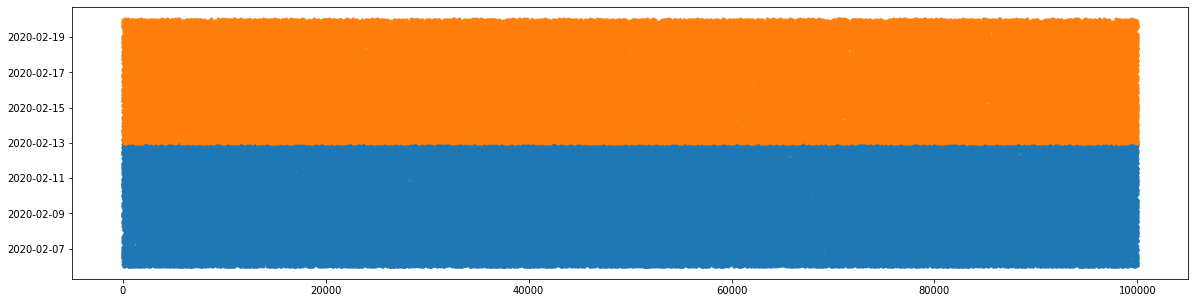

In [52]:
plt.figure(figsize=(20,5))
plt.plot(df.tm_dt, '.')
plt.plot(dfval.tm_dt, '.')

2020-02-09 11:44:27.062659584 2020-02-16 11:34:12.728294656


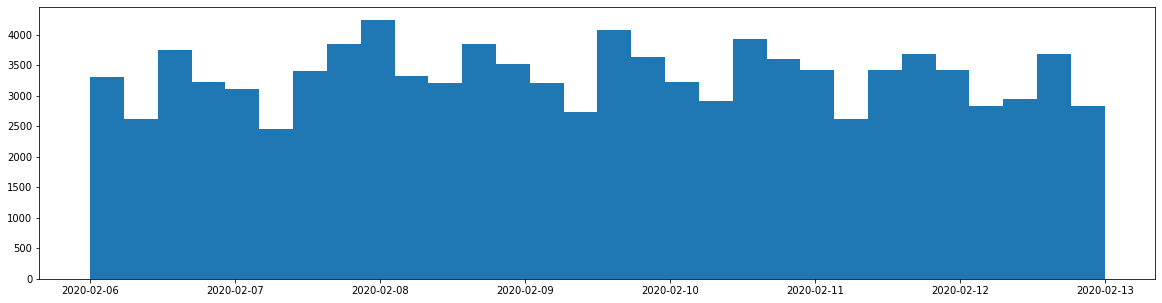

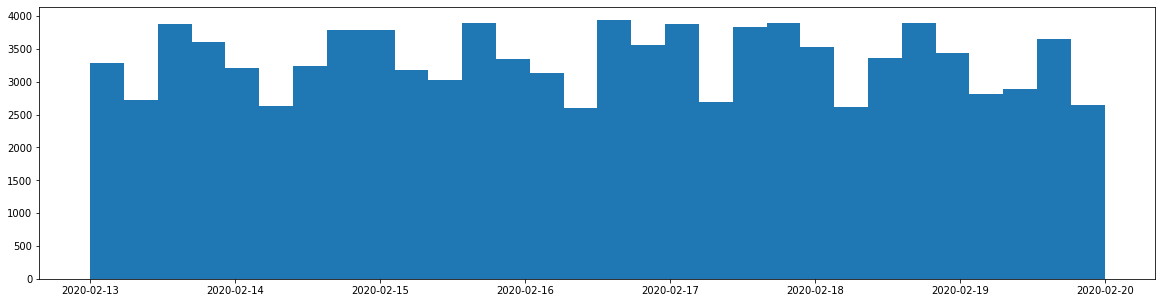

In [53]:
print(df.tm_dt.mean(), dfval.tm_dt.mean())
plt.figure(figsize=(20,5))
plt.hist(df.tm_dt,30)
plt.show()
plt.figure(figsize=(20,5))
plt.hist(dfval.tm_dt,30)
plt.show()

303331.93734 303946.2717


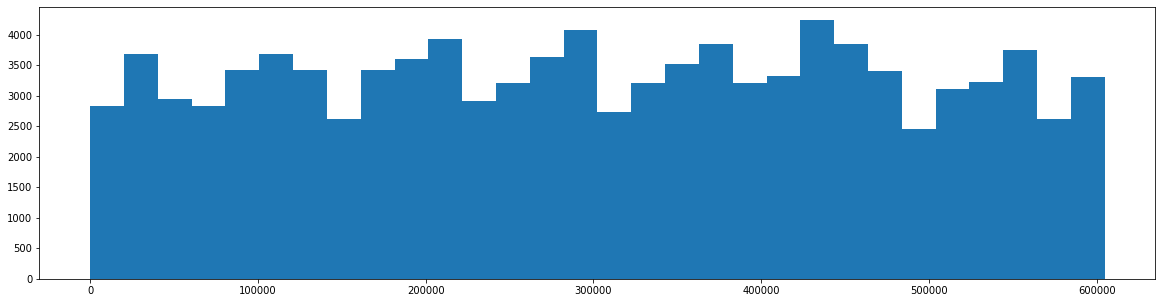

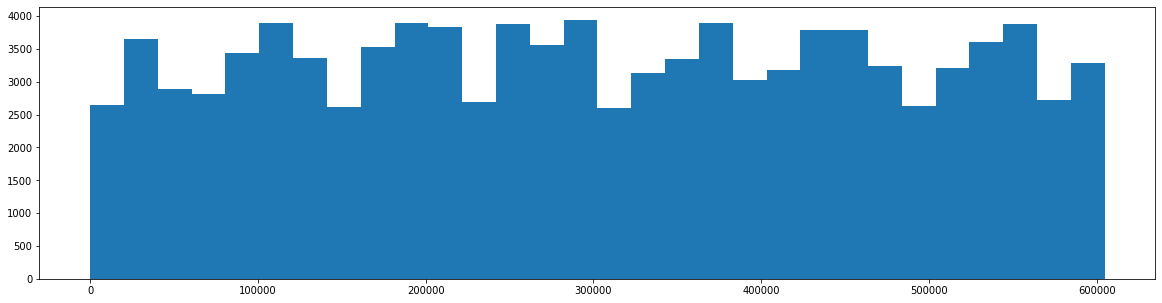

In [54]:
print(df.tmleft_twt.mean(),dfval.tmleft_twt.mean())
plt.figure(figsize=(20,5))
plt.hist(df.tmleft_twt,30)
plt.show()
plt.figure(figsize=(20,5))
plt.hist(dfval.tmleft_twt,30)
plt.show()

## u1 create time

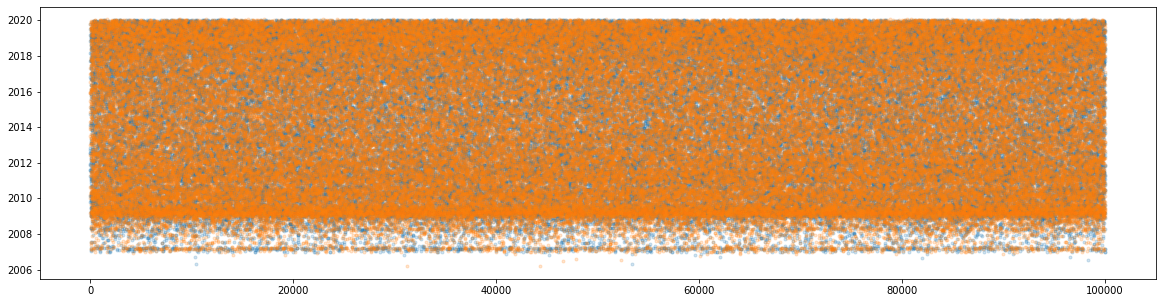

In [55]:
plt.figure(figsize=(20,5))
plt.plot(df.u1_create_tm_dt, '.', alpha=0.2)
plt.plot(dfval.u1_create_tm_dt, '.',alpha=0.2)

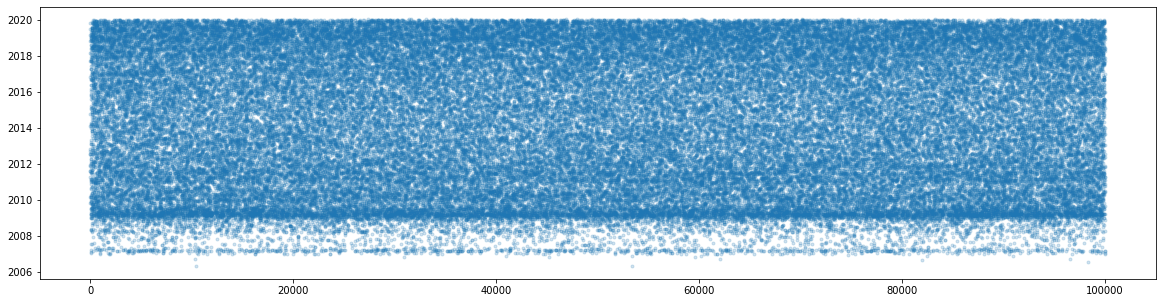

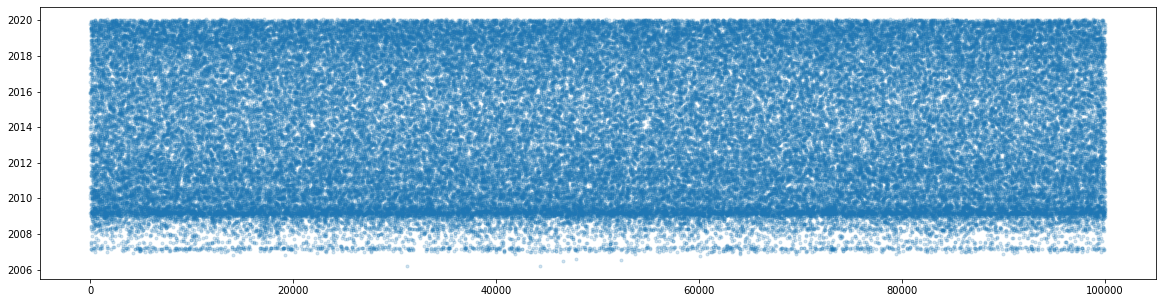

In [56]:
plt.figure(figsize=(20,5))
plt.plot(df.u1_create_tm_dt, '.', alpha=0.2)
plt.show()
plt.figure(figsize=(20,5))
plt.plot(dfval.u1_create_tm_dt, '.',alpha=0.2)
plt.show()

2014-04-19 04:56:18.880182016 2014-01-05 03:01:52.562584576


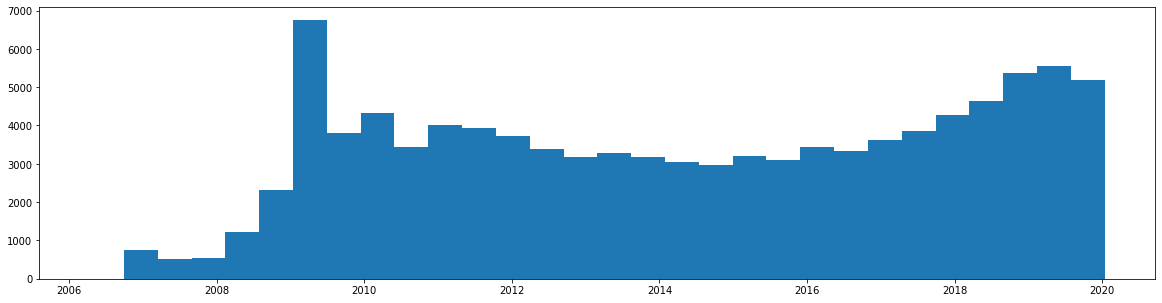

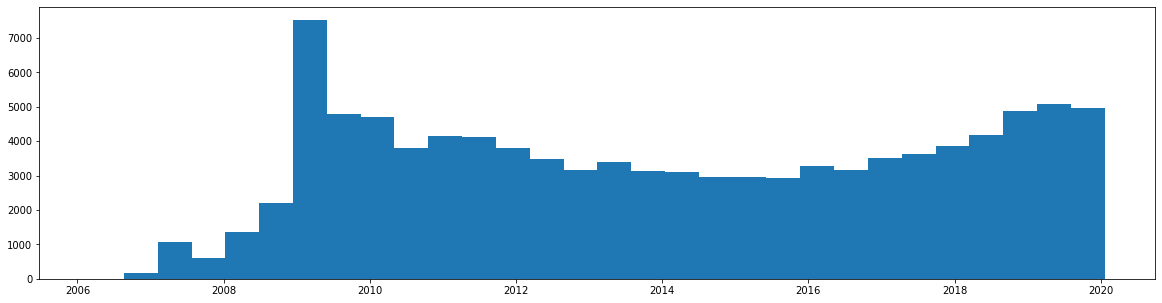

In [57]:
print(df.u1_create_tm_dt.mean(), dfval.u1_create_tm_dt.mean())
plt.figure(figsize=(20,5))
plt.hist(df.u1_create_tm_dt,30)
plt.show()
plt.figure(figsize=(20,5))
plt.hist(dfval.u1_create_tm_dt,30)
plt.show()

In [66]:
# user at least 30 days old 
print(df.tmleft_u1.min()/secs_per_day,dfval.tmleft_u1.min()/secs_per_day)

30.265011574074073 30.650497685185186


30.265011574074073 30.650497685185186
183668620.11983 193265886.43742


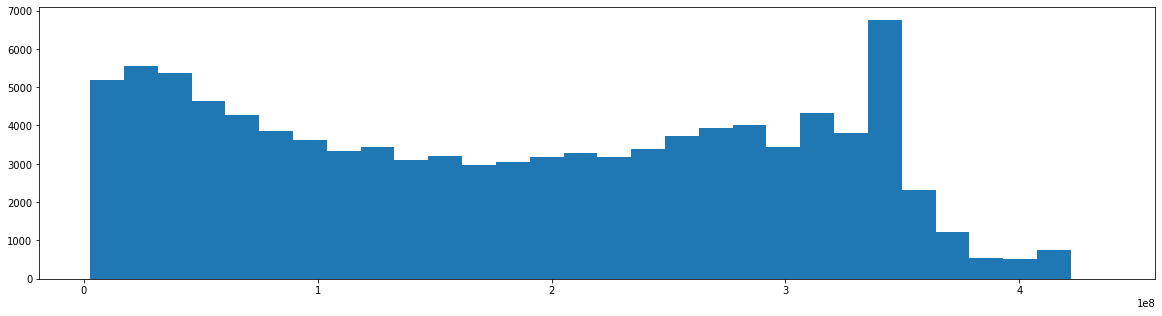

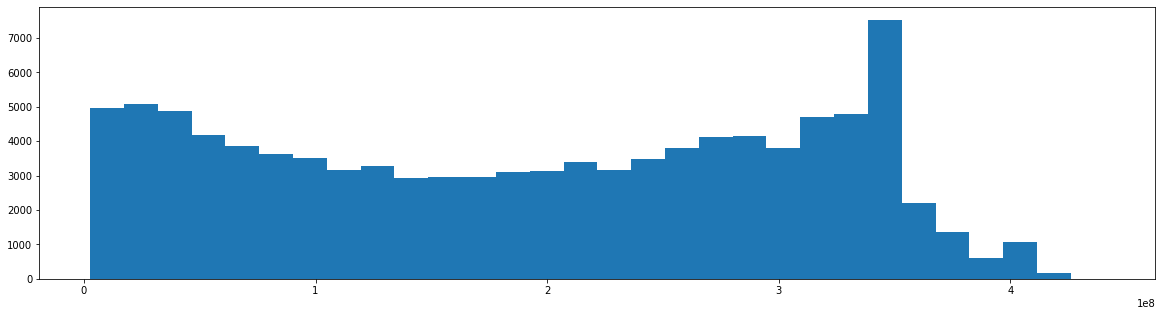

In [63]:
print(df.tmleft_u1.mean(),dfval.tmleft_u1.mean())
plt.figure(figsize=(20,5))
plt.hist(df.tmleft_u1,30)
plt.show()
plt.figure(figsize=(20,5))
plt.hist(dfval.tmleft_u1,30)
plt.show()

## u2 create time

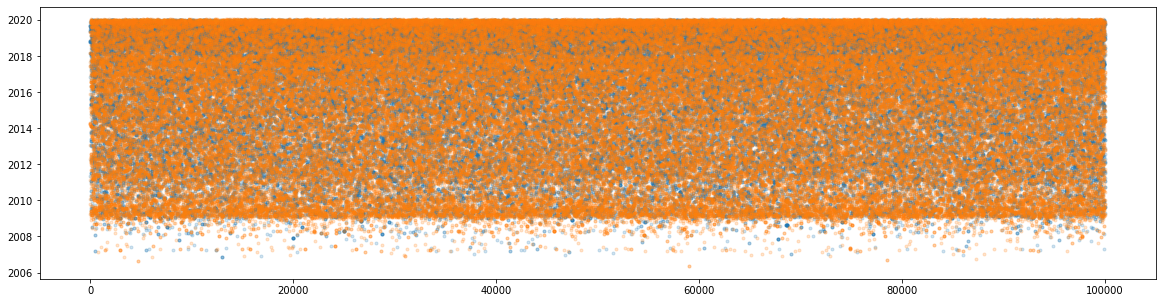

In [59]:
plt.figure(figsize=(20,5))
plt.plot(df.u2_create_tm_dt, '.', alpha=0.2)
plt.plot(dfval.u2_create_tm_dt, '.',alpha=0.2)

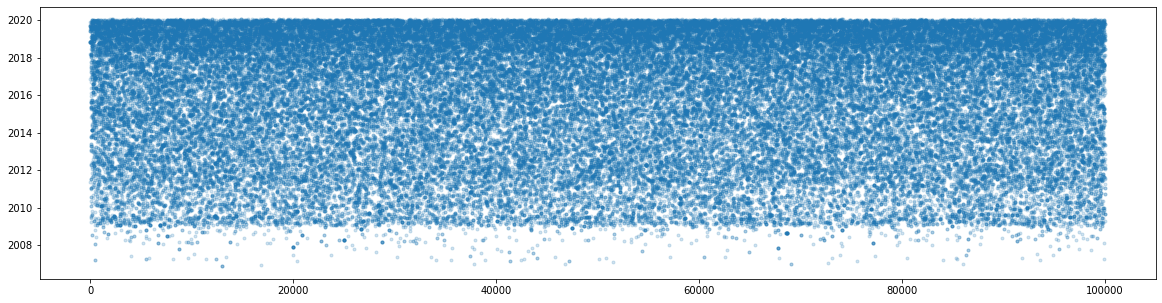

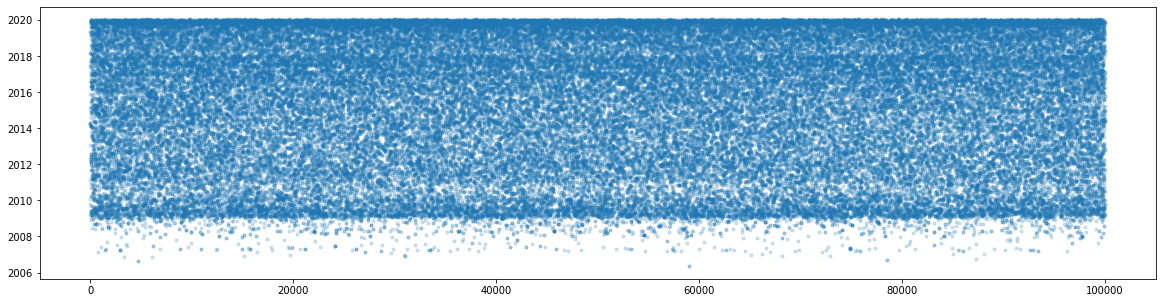

In [60]:
plt.figure(figsize=(20,5))
plt.plot(df.u2_create_tm_dt, '.', alpha=0.2)
plt.show()
plt.figure(figsize=(20,5))
plt.plot(dfval.u2_create_tm_dt, '.',alpha=0.2)
plt.show()

2016-01-24 15:47:10.505008640 2015-04-18 10:20:51.868000768


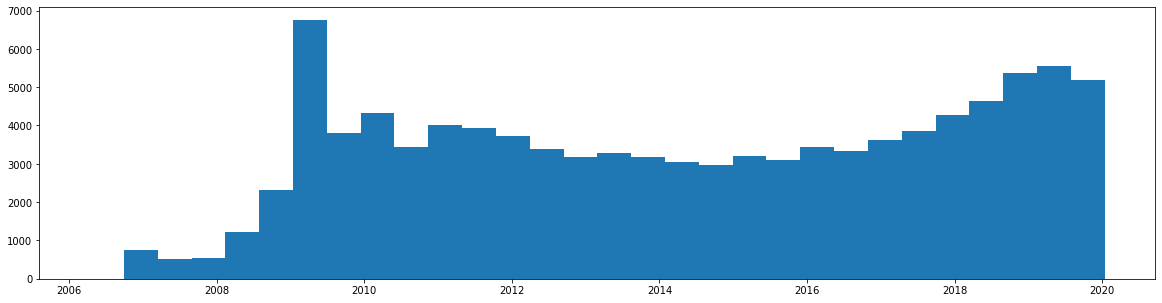

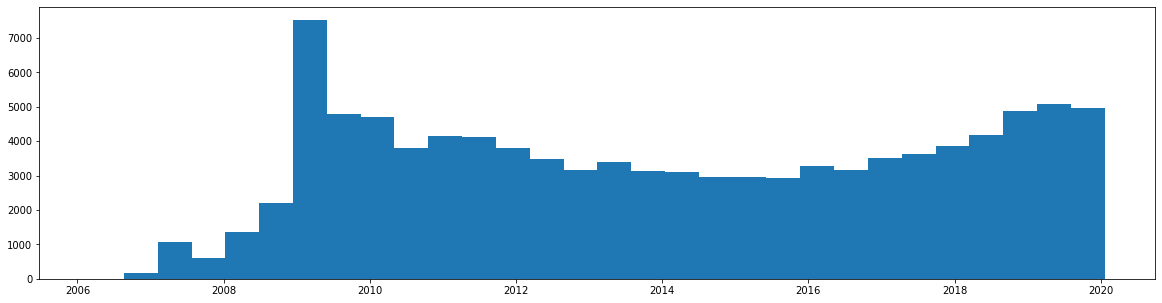

In [61]:
print(df.u2_create_tm_dt.mean(), dfval.u2_create_tm_dt.mean())
plt.figure(figsize=(20,5))
plt.hist(df.u1_create_tm_dt,30)
plt.show()
plt.figure(figsize=(20,5))
plt.hist(dfval.u1_create_tm_dt,30)
plt.show()

In [65]:
# user at least 30 days old 
print(df.tmleft_u2.min()/secs_per_day,dfval.tmleft_u2.min()/secs_per_day)

30.003194444444443 31.019039351851852


30.003194444444446 31.01903935185185
127901568.49498 152804347.13202


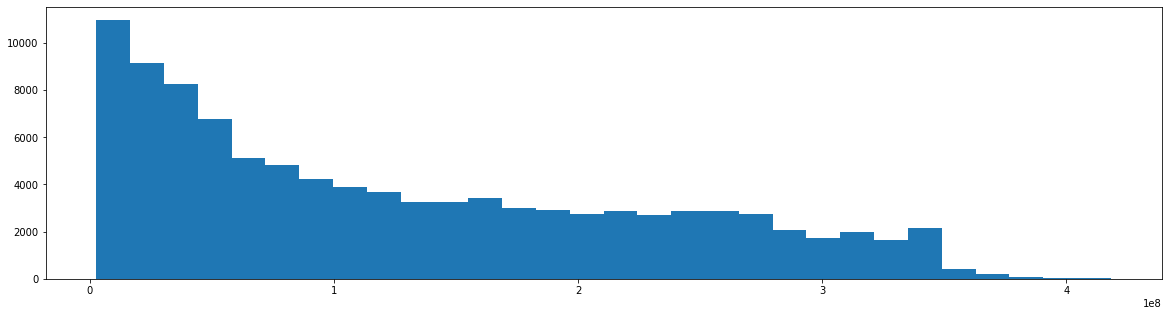

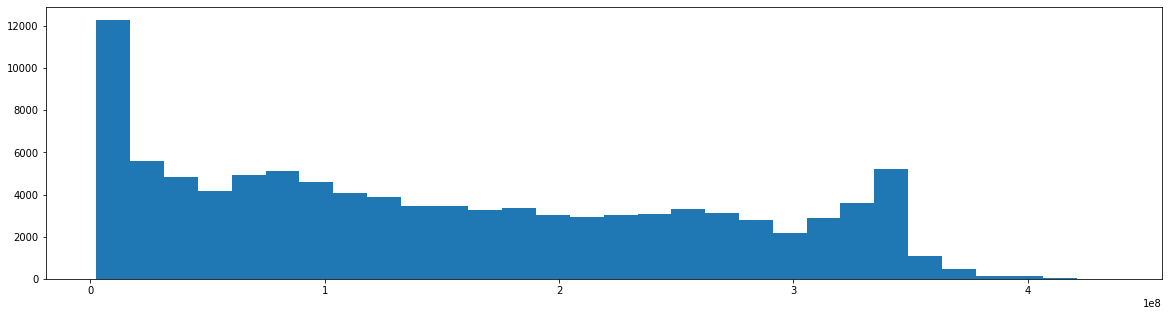

In [50]:
print(df.tmleft_u2.mean(),dfval.tmleft_u2.mean())
plt.figure(figsize=(20,5))
plt.hist(df.tmleft_u2,30)
plt.show()
plt.figure(figsize=(20,5))
plt.hist(dfval.tmleft_u2,30)
plt.show()

## v.s. target

In [505]:
df.groupby(['enged'])['tmdlta_twt_until'].mean()

KeyError: 'Column not found: tmdlta_twt_until'

In [224]:
df.columns

Index(['toks', 'hshtgs', 'twtid', 'media', 'links', 'domns', 'twttyp', 'lang',
       'tm', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2id', 'u2_follower_cnt', 'u2_following_cnt',
       'u2_vrfed', 'u2_create_tm', 'u1_fllw_u2', 'reply_tm', 'retwt_tm',
       'retwt_cmmnt_tm', 'like_tm', 'tokids', 'len_toks', 'tm_dt',
       'tm_dayofweek', 'tm_day', 'tm_hour', 'retwt_tm_dt',
       'retwt_tm_dayofweek', 'retwt_tm_day', 'retwt_tm_hour', 'reply_tm_dt',
       'reply_tm_dayofweek', 'reply_tm_day', 'reply_tm_hour', 'like_tm_dt',
       'like_tm_dayofweek', 'like_tm_day', 'like_tm_hour', 'retwt_cmmnt_tm_dt',
       'retwt_cmmnt_tm_dayofweek', 'retwt_cmmnt_tm_day', 'retwt_cmmnt_tm_hour',
       'tmdlta_u2u1', 'tmdlta_twtu1', 'tmdlta_twtu2', 'tmdlta_twt_until',
       'retwt', 'reply', 'like', 'retwt_cmmnt', 'enged'],
      dtype='object')

In [225]:
df.groupby('tm_dayofweek')['enged'].mean()

tm_dayofweek
0    0.512890
1    0.524217
2    0.471616
3    0.511662
4    0.510985
5    0.542025
6    0.519945
Name: enged, dtype: float64

In [228]:
df.groupby('tm_hour')['enged'].mean()

tm_hour
0     0.518957
1     0.550117
2     0.532294
3     0.535556
4     0.504373
5     0.530675
6     0.589342
7     0.520000
8     0.495495
9     0.465257
10    0.517711
11    0.498851
12    0.517483
13    0.528376
14    0.525424
15    0.503731
16    0.511858
17    0.501139
18    0.503529
19    0.503632
20    0.502232
21    0.472603
22    0.562780
23    0.445727
Name: enged, dtype: float64

In [231]:
for lang in langs[:10]:
    display(df[df.lang==lang].groupby(['tm_hour'])['enged'].mean())

tm_hour
0     0.534653
1     0.512315
2     0.560209
3     0.532663
4     0.513889
5     0.503597
6     0.570370
7     0.475000
8     0.417582
9     0.454545
10    0.500000
11    0.459854
12    0.572581
13    0.517241
14    0.488889
15    0.463303
16    0.506383
17    0.485981
18    0.497585
19    0.463636
20    0.427984
21    0.452586
22    0.547826
23    0.427835
Name: enged, dtype: float64

tm_hour
0     0.549020
1     0.569231
2     0.424242
3     0.516854
4     0.433333
5     0.546875
6     0.539683
7     0.491803
8     0.524272
9     0.540541
10    0.547170
11    0.472441
12    0.558559
13    0.540816
14    0.478261
15    0.465909
16    0.357143
17    0.482759
18    0.384615
19    0.555556
20    0.769231
21    0.576923
22    0.574074
23    0.437500
Name: enged, dtype: float64

tm_hour
0     0.491228
1     0.562500
2     0.467742
3     0.581395
4     0.428571
5     0.517241
6     0.538462
7     0.583333
8     0.500000
9     0.357143
10    0.571429
11    0.714286
12    0.588235
13    0.468085
14    0.533333
15    0.509804
16    0.487805
17    0.425532
18    0.431373
19    0.566038
20    0.416667
21    0.400000
22    0.585366
23    0.387755
Name: enged, dtype: float64

tm_hour
0     0.425000
1     0.543478
2     0.521739
3     0.434783
4     0.714286
5     0.750000
6     0.909091
7     1.000000
8     0.666667
9     0.000000
10    0.428571
11    0.571429
12    0.321429
13    0.566667
14    0.606061
15    0.689655
16    0.476190
17    0.567568
18    0.457143
19    0.529412
20    0.709677
21    0.551724
22    0.580645
23    0.425926
Name: enged, dtype: float64

tm_hour
0     0.526316
1     0.684211
2     0.608696
3     0.514286
4     0.409091
5     0.687500
6     0.437500
7     0.615385
8     0.285714
9     0.500000
10    0.450000
11    0.461538
12    0.454545
13    0.533333
14    0.590909
15    0.440000
16    0.571429
17    0.368421
18    0.692308
19    0.611111
20    0.440000
21    0.518519
22    0.454545
23    0.400000
Name: enged, dtype: float64

tm_hour
0     0.500000
1     1.000000
2     0.666667
3     0.000000
4     0.333333
5     0.714286
6     0.714286
7     0.692308
8     0.647059
9     0.555556
10    0.428571
11    0.666667
12    0.500000
13    0.473684
14    0.454545
15    0.555556
16    0.733333
17    0.590909
18    0.695652
19    0.652174
20    0.724138
21    0.541667
22    0.684211
23    0.538462
Name: enged, dtype: float64

tm_hour
0     0.714286
1     0.571429
2     0.600000
3     0.571429
4     0.000000
5     0.400000
6     0.454545
7     0.700000
8     0.444444
9     0.500000
10    0.266667
11    0.454545
12    0.454545
13    0.500000
14    0.727273
15    0.650000
16    0.466667
17    0.368421
18    0.416667
19    0.384615
20    0.583333
21    0.476190
22    0.466667
23    0.700000
Name: enged, dtype: float64

tm_hour
0     0.800000
1     1.000000
2     0.666667
3     0.333333
6     0.555556
7     0.500000
8     0.500000
9     0.272727
10    0.583333
11    0.625000
12    0.333333
13    0.666667
14    0.416667
15    0.416667
16    0.583333
17    0.500000
18    0.375000
19    0.416667
20    0.578947
21    0.357143
22    0.555556
23    0.600000
Name: enged, dtype: float64

tm_hour
0     0.000000
1     0.666667
2     0.750000
3     0.545455
4     0.777778
5     0.375000
6     0.818182
7     0.357143
8     0.466667
9     0.416667
10    0.583333
11    0.454545
12    0.214286
13    0.571429
14    0.625000
15    0.600000
16    0.571429
17    0.833333
18    0.000000
19    0.333333
20    1.000000
21    0.500000
22    0.750000
23    0.000000
Name: enged, dtype: float64

tm_hour
0     0.666667
1     0.555556
2     0.666667
3     0.428571
4     0.538462
5     0.666667
6     0.875000
7     0.714286
8     0.636364
9     0.500000
10    0.833333
11    0.909091
12    0.727273
13    0.533333
14    0.700000
15    0.875000
16    0.590909
17    1.000000
18    1.000000
21    1.000000
22    1.000000
23    1.000000
Name: enged, dtype: float64

# tags

In [514]:
def get_tag_frq(df, tag):
    tag_all = [j for i in df[tag] for j in i]
    cnt = Counter(tag_all)
    lndf=len(df)
    frq = {k:v/lndf for k,v in cnt.items()}
    return frq

tag2frq_trn = {}
tag2frq_val = {}
for tag in tags:
    tag2frq_trn[tag]=get_tag_frq(df, tag)
    tag2frq_val[tag]=get_tag_frq(dfval, tag)

In [521]:
df.media.value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1652, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[]                              6197
[Photo]                         1824
[Video]                         1071
[Photo, Photo]                   403
[Photo, Photo, Photo, Photo]     237
[Photo, Photo, Photo]            144
[GIF]                            124
Name: media, dtype: int64

In [518]:
tag2frq_trn['media']

{'Photo': 0.401, 'Video': 0.1071, 'GIF': 0.0124}

In [510]:
Counter(tag_all).most_common()

[('B6024D6F02AFAF9BC8ED941F72C228F1', 31),
 ('5671B8B6E92C2A316C05A7CD2F17366C', 23),
 ('18F6AC96A6EA62716A47DE9FE6241534', 13),
 ('E78674D323461112D0DCF8010AF5AED3', 12),
 ('746E379897167C3B81A180BF8BAADD8D', 10),
 ('F564E2BDCB9A0ABADDD4A9EE053DFCD2', 9),
 ('31C316EB7BB8CD1778CB83B8AA2603D9', 9),
 ('F3A652C947EB7F5D093A48E95EFC62F5', 8),
 ('DC286E92F82ADF9A92C522D3634F83A9', 8),
 ('1E8BB1B1D7FB3FB8DF86A9AC39E5CBFD', 7),
 ('90737D9DA900CC58060430C656F7935D', 7),
 ('9887C2F9C8FFECE3524054D91E871F84', 7),
 ('F2AA2F668B2C6FF79297EB03A516166A', 7),
 ('C436C314406D18BB3D818D908A638464', 7),
 ('BB67E3D30479A50AB5F81AAEBFB3A06B', 7),
 ('EAF82AB9A72531F46B47E64F6950727D', 7),
 ('FB5A802DF7D5F25412425F0B91B1D7A7', 7),
 ('EA152CAF6EE7894E914C522BD1B5E702', 6),
 ('2CEA75FAF2E370E6961FE81437C2FA65', 6),
 ('54F99ADBF86DDABAAA497099FB26D956', 6),
 ('AECAC0E3D6E18B21C330B1BA22459CED', 6),
 ('0C262F0DB4032AE0B26F1E28B9291F34', 6),
 ('F0F2FBE57F08E7C4326682B5EDA63E3E', 5),
 ('B035184A46EF5CA2FB20B9FDDC

In [412]:
tag_all

['',
 '',
 '',
 'F0F2FBE57F08E7C4326682B5EDA63E3E',
 'E78674D323461112D0DCF8010AF5AED3',
 '',
 'C38F925CF76111352C3FE0EFBA8F32B6',
 '7E881DBFB094FB9EC5974FD3958C5747',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '83D6C79F5FCEC8D1CAD9E82C2C261611',
 'FFAD2DCF664C9B5C76C720961ABBECA7',
 'BC1422EDBF127C5791A4F0DC2ABB6DCD',
 'C150C6FAE89F1CA176BC6576AE2A7553',
 'AB097FCD60F2F25930882EDB8FC8C2B8',
 '',
 '',
 '',
 '',
 '66807966511B4D7BEF80A66AD93BAB18',
 '19A6E6382BCA3BFA88CFCE94FC1C0181',
 '86E7C6317A95585B495E0CFA474FD12B',
 '35DA9DA4F9A87CA320FE04791AAC04ED',
 '36F30FE148CE5EA75587DA8CC3802D2D',
 '5A8EF9C74AE21F0D6A5E690E9CE01143',
 'CF344E85A455E73A1436AD017C05166D',
 '36E2D9A2DF37ADF996C7127E824BEE12',
 '',
 '',
 '9050E1FCB5DC1ADECAFC78C5496EEE8C',
 '',
 '',
 '',
 '82ADB85CF5815104A48230ABB16472D7',
 'A12C1BAED8C3A4CF42E79391427E3F7D',
 'A12C1BAED8C3A4CF42E79391427E3F7D',
 '0510F08F2EC20470D047501D20E758EE',
 'C61B0F98CD195E1D8EF04B94A599657C',
 '045024B0E2C9A4B3A60AAF1F39BA309F',
 '

In [408]:
df[tag]

0                                                      []
1                                                      []
2                                                      []
3       [F0F2FBE57F08E7C4326682B5EDA63E3E, E78674D3234...
4                                                      []
                              ...                        
9995                                                   []
9996                                                   []
9997                                                   []
9998                   [4AB1D21567BBE4926C3F8AF3A4B70508]
9999                                                   []
Name: hshtgs, Length: 10000, dtype: object

In [365]:
df['hshtgs'].notna().mean()

1.0

In [366]:
df['hshtgs'].fillna('').apply(lambda x: x.split('\t'))

AttributeError: 'list' object has no attribute 'split'

In [55]:
print([showtm(tm) for tm in (df.tm.min(),df.tm.max())])
print([showtm(tm) for tm in (df.reply_tm.min(),df.reply_tm.max())])


['2020-02-06 00:00:02', '2020-02-12 23:59:01']
['2020-02-06 00:10:49', '2020-02-12 23:28:11']


In [60]:
dfval.lang.value_counts()/lndfval

D3164C7FBCF2565DDF915B1B3AEFB1DC    4.344798e-01
22C448FF81263D4BAF2A176145EE9EAD    1.560285e-01
06D61DCBBE938971E1EA0C38BD9B5446    8.845777e-02
ECED8A16BE2A5E8871FD55F4842F16B1    7.043334e-02
B9175601E87101A984A50F8A62A1C374    5.070714e-02
4DC22C3F31C5C43721E6B5815A595ED6    3.093182e-02
167115458A0DBDFF7E9C0C53A83BAC9B    2.808883e-02
022EC308651FACB02794A8147AEE1B78    2.179995e-02
125C57F4FA6D4E110983FB11B52EFD4E    2.049353e-02
FA3F382BC409C271E3D6EAF8BE4648DD    2.047157e-02
9BF3403E0EB7EA8A256DA9019C0B0716    1.612918e-02
975B38F44D65EE42A547283787FF5A21    9.035725e-03
2996EB2FE8162C076D070A4C8D6532CD    7.845869e-03
FF60A88F53E63000266F8B9149E35AD9    5.542947e-03
717293301FE296B0B61950D041485825    5.440537e-03
3820C29CBCA409A33BADF68852057C4A    5.090584e-03
3E16B11B7ADE3A22DDFC4423FBCEAD5D    5.043989e-03
9ECD42BC079C20F156F53CB3B99E600E    2.567850e-03
76B8A9C3013AE6414A3E6012413CDC3B    2.432993e-03
AEF22666801F0A5846D853B9CEB2E327    2.231974e-03
190BA7DA361BC06BC1D7

In [75]:
df.lang.value_counts()/lndf

D3164C7FBCF2565DDF915B1B3AEFB1DC    0.411550
22C448FF81263D4BAF2A176145EE9EAD    0.160280
06D61DCBBE938971E1EA0C38BD9B5446    0.089432
ECED8A16BE2A5E8871FD55F4842F16B1    0.069332
B9175601E87101A984A50F8A62A1C374    0.052802
4DC22C3F31C5C43721E6B5815A595ED6    0.034278
167115458A0DBDFF7E9C0C53A83BAC9B    0.031474
125C57F4FA6D4E110983FB11B52EFD4E    0.024444
022EC308651FACB02794A8147AEE1B78    0.022524
FA3F382BC409C271E3D6EAF8BE4648DD    0.022180
9BF3403E0EB7EA8A256DA9019C0B0716    0.018434
975B38F44D65EE42A547283787FF5A21    0.009488
2996EB2FE8162C076D070A4C8D6532CD    0.009152
3E16B11B7ADE3A22DDFC4423FBCEAD5D    0.005426
3820C29CBCA409A33BADF68852057C4A    0.005262
717293301FE296B0B61950D041485825    0.004770
FF60A88F53E63000266F8B9149E35AD9    0.004578
76B8A9C3013AE6414A3E6012413CDC3B    0.002670
9ECD42BC079C20F156F53CB3B99E600E    0.002612
AEF22666801F0A5846D853B9CEB2E327    0.002306
190BA7DA361BC06BC1D7E824C378064D    0.002120
1FFD2FE4297F5E70EBC6C3230D95CB9C    0.001834
48236EC80F

# old

# prepare data

## get maps from dfval

In [11]:
# dfval=dd.read_csv(
#     f'{p_in}/val_{valtmstmp}.tsv',
#     sep='\x01', header=None, names=cols_val,)
# lang2cnt=dict(dfval.lang.value_counts().compute())
# ttl=sum(lang2cnt.values())
# lang2perc={k:v/ttl for k,v in lang2cnt.items()}
# langs=['D3164C7FBCF2565DDF915B1B3AEFB1DC', '22C448FF81263D4BAF2A176145EE9EAD', '06D61DCBBE938971E1EA0C38BD9B5446', 'ECED8A16BE2A5E8871FD55F4842F16B1', 'B9175601E87101A984A50F8A62A1C374', '4DC22C3F31C5C43721E6B5815A595ED6', '167115458A0DBDFF7E9C0C53A83BAC9B', '125C57F4FA6D4E110983FB11B52EFD4E', '022EC308651FACB02794A8147AEE1B78', 'FA3F382BC409C271E3D6EAF8BE4648DD', '9BF3403E0EB7EA8A256DA9019C0B0716', '975B38F44D65EE42A547283787FF5A21', '2996EB2FE8162C076D070A4C8D6532CD', 'FF60A88F53E63000266F8B9149E35AD9', '717293301FE296B0B61950D041485825', '3E16B11B7ADE3A22DDFC4423FBCEAD5D', '3820C29CBCA409A33BADF68852057C4A', '9ECD42BC079C20F156F53CB3B99E600E', '76B8A9C3013AE6414A3E6012413CDC3B', 'AEF22666801F0A5846D853B9CEB2E327', '190BA7DA361BC06BC1D7E824C378064D', '1FFD2FE4297F5E70EBC6C3230D95CB9C', 'A0C7021AD8299ADF0C9EBE326C115F6F', 'D413F5FE5236E5650A46FD983AB39212', '48236EC80FDDDFADE99420ABC9210DDF', '691890251F2B9FF922BE6D3699ABEFD2', '920502FAA080485768AA89BC96A55C47', '0331BF70E606D62D92C96CE9AD71A7CF', '89616CFF8EC8637092F885C7EFF43D74', '06BEAB41D66CCFF329D1ED8BA120A6C2', '60FBA0E834CC59D647C3599AD763FFDF', 'C7A400D9AD489ACF673CF12FBB80AAE5', 'E59EF8BB86A6D815331DDF4C467CE0C7', '4249CE88433AEA3F8DCEECF008B3CB95', '544FA32458C903F1125FE6598300A047', 'CB11E9CF42BD0A1BAD5E27BF3422D99D', '3A85BCEC571C3F5AB1069E4924189177', 'FF7EABB5A382356D54D9C41BA0125E09', 'E7BB61D2A87C1E72DF1C7BC292B86A1C', '69C4A33B9AD29AF883D60BA61CC08702', 'F4FD40A716F1572C9A28E9CAA58BE3A5', '259A6F6DFD672CB1F883CBEC01B99F2D', '6431A618DCF7F4CB7F62A95A39BAB77A', '3121F7240D488F74EEED9312E174B217', '54208B51D44E7D91DC2F3DD02ADEDEC2', 'DBEEFB80F8A314311E2B4BD593E11DFE', 'B6D90127A09AB1229731898AEF9D4D7C', 'F3E1016563360F9434FA986CA86C249C', '2216D01F7B48554E4211021A46816FCF', '1BC639981AE88E09129594B11F894A21', 'C942E369C88CE7C56E69A84D04319FF0', '57ADD4576E2AD6648E9B2DE32F3462A5', 'AC1F0671A4B0D5B8112F87DE7B490E6D', 'C2EF5FABE7619D8A333D5F0FF76E1BFA', 'AA0254541959271ED3453119B787D0C3', 'A6B70CDF8C7B934D4A218CA9B6B7FDB4', 'BF477808A37E3E4E9C5D9F1839E8519E', '97F81BD92A1ACA3F1F43C154E689350F', '60A3DB168094D41241E45E0DE3539BC0', '12D8CEB94F89D11D7EB95EAE9689B009', 'F73266A79468BB89C4325FDEDB0B533C', '4690215948DBF6872B8ED1C2BC87B17E', 'D18801336202297E6484F634CAC6592E', '2E18F6F53E3CF073911AF0A93BBE5373', 'B2235C8B73239FDC5780DD132419833A', '515E873C86EE1577E75FA2387B7FA59E',]

# dfval.twttyp.value_counts().compute()
# TopLevel    2932
# Retweet      994
# Quote        213
twttyps=['TopLevel','Retweet','Quote']

In [13]:
def prp_df(df, istrn=True):
    df['len_toks']=df.toks.apply(len)
    for media in ['Photo', 'Video', 'GIF']:
        df[f'has_media_{media}'] = df.media.fillna('').apply(lambda x: media in x)
    for col in ['hshtgs', 'links', 'domns',]:
        df[f'num_{col}'] = df[col].fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0)
    tm_dt=pd.to_datetime(df.tm, unit='s')
    df['tm_month']=tm_dt.dt.month
    df['tm_dayofweek']=tm_dt.dt.dayofweek
    df['tm_day']=tm_dt.dt.day
    df['tm_hour']=tm_dt.dt.hour
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm

    for typ in twttyps:
        df[f'twttyp_{typ}']=(df.twttyp==typ).astype('int8')

#     for lang in langs:
#         df[f'lang_{lang}']=(df.lang==lang).astype('int8')
    if istrn: 
        df[cols_tgt]=df[cols_tgt_tmstmp].notna().astype('int8')
#         df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 'twtid', 'u1id', 'u2id']+cols_tgt_tmstmp, )
#     else:
#         df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 'u1id',])        
    return df

In [14]:
grand_total

150000000.0

In [15]:
grand_total/1e6

150.0

In [16]:
chnks_trn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',
                    header=None,names=cols, 
                        chunksize=1e6
                       )

np.random.seed(SEED)
lst_df = []
for ichnk,df in enumerate(chnks_trn):
    print(dtnow(), 'chunk', ichnk)
    df = prp_df(df)    
    lst_df.append(df)
    if ichnk>=0: break



2020-03-20 12:00:32 chunk 0


In [17]:
df = pd.concat(lst_df)

In [18]:
df.shape

(1000000, 45)

In [19]:
df.columns

Index(['toks', 'hshtgs', 'twtid', 'media', 'links', 'domns', 'twttyp', 'lang',
       'tm', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2id', 'u2_follower_cnt', 'u2_following_cnt',
       'u2_vrfed', 'u2_create_tm', 'u1_fllw_u2', 'reply_tm', 'retwt_tm',
       'retwt_cmmnt_tm', 'like_tm', 'len_toks', 'has_media_Photo',
       'has_media_Video', 'has_media_GIF', 'num_hshtgs', 'num_links',
       'num_domns', 'tm_month', 'tm_dayofweek', 'tm_day', 'tm_hour',
       'tmdlta_u2u1', 'tmdlta_twtu1', 'tmdlta_twtu2', 'twttyp_TopLevel',
       'twttyp_Retweet', 'twttyp_Quote', 'retwt', 'reply', 'like',
       'retwt_cmmnt'],
      dtype='object')

In [24]:
df[cols_tgt].mean(0)

retwt          0.113135
reply          0.027688
like           0.438804
retwt_cmmnt    0.007750
dtype: float64

In [20]:
cols_feat=[o for o in df.columns if o not in cols_tgt]

In [21]:
twtid2cnt = df.twtid.value_counts()

In [25]:
twtid2cnt.value_counts()

1      854024
2       34357
3        8462
4        3272
5        1544
        ...  
45          1
44          1
43          1
42          1
209         1
Name: twtid, Length: 65, dtype: int64

In [26]:
df.u1id.value_counts().value_counts()

1      459596
2       54719
3       17941
4        8504
5        5173
        ...  
203         1
202         1
195         1
194         1
506         1
Name: u1id, Length: 255, dtype: int64

In [27]:
df.groupby('u1id')[cols_tgt].mean()

retwt  reply  like  retwt_cmmnt
u1id                                                             
00000B85AAF7DE172876FD96718C4469    0.0    0.0   1.0          0.0
00001CAFC250AADA5EBD1ACA9E7735A7    0.4    0.0   0.4          0.0
00005B5734CD2CB88CBD541ADEBA0F4F    0.0    0.0   0.0          0.0
0000675DCCACC60EBD6730C8B045C63D    0.0    0.0   1.0          0.0
00008B478D82B199E1061ADF702A588F    0.0    0.0   1.0          0.0
...                                 ...    ...   ...          ...
FFFFACEC95F443309C369B0514BE7068    0.0    0.0   1.0          0.0
FFFFBBBA844C8E8735007950D1AD647B    0.0    0.0   0.0          0.0
FFFFC9F9460972DD941E2A8D17A44A8B    0.0    0.0   0.0          0.0
FFFFCA5818D76E30780A5DF6C5F17718    0.0    0.0   1.0          0.0
FFFFDEAF063BACDC2AA82D118757E5D0    0.0    0.0   0.0          0.0

[563630 rows x 4 columns]

In [28]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{valtmstmp}.tsv',
#     f'{p_in}/val_259A6F6DFD672CB1F883CBEC01B99F2D_1584405047.tsv',
    sep='\x01', header=None, names=cols_val,)


CPU times: user 2min 35s, sys: 11 s, total: 2min 46s
Wall time: 3min


In [30]:
dftst.tm.min()

1581552000

In [32]:
df.tm.min()

1580947200

In [34]:
print([datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (df.tm.min(), dftst.tm.min())])


['2020-02-06 00:00:00', '2020-02-13 00:00:00']


In [ ]:
# setup

from pathlib import Path
import dask
print('dask.__version__', dask.__version__)
import xgboost as xgb
import dask_xgboost
import dask.dataframe as dd
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from dask.distributed import Client
import pickle
import lightgbm as lgb
from tqdm import tqdm

import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

SEED=101
HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

cols=[
'toks',
'hshtgs',
'twtid',
'media',
'links',
'domns',
'twttyp',
'lang',
'tm',

'u1id',
'u1_fllwer_cnt',
'u1_fllwing_cnt',
'u1_vrfed',
'u1_create_tm',

'u2id',
'u2_follower_cnt',
'u2_following_cnt',
'u2_vrfed',
'u2_create_tm',

'u1_fllw_u2',
'reply_tm',
'retwt_tm',
'retwt_cmmnt_tm',
'like_tm',
]

cols_val = cols[:-4]
cols_tgt_tmstmp=[
    'retwt_tm',
    'reply_tm',
    'like_tm',
    'retwt_cmmnt_tm',
]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
ntgts=len(tgts)

# prepare data

## get maps from dfval

# dfval=dd.read_csv(
#     f'{p_in}/val_{valtmstmp}.tsv',
#     sep='\x01', header=None, names=cols_val,)
# lang2cnt=dict(dfval.lang.value_counts().compute())
# ttl=sum(lang2cnt.values())
# lang2perc={k:v/ttl for k,v in lang2cnt.items()}
# langs=['D3164C7FBCF2565DDF915B1B3AEFB1DC', '22C448FF81263D4BAF2A176145EE9EAD', '06D61DCBBE938971E1EA0C38BD9B5446', 'ECED8A16BE2A5E8871FD55F4842F16B1', 'B9175601E87101A984A50F8A62A1C374', '4DC22C3F31C5C43721E6B5815A595ED6', '167115458A0DBDFF7E9C0C53A83BAC9B', '125C57F4FA6D4E110983FB11B52EFD4E', '022EC308651FACB02794A8147AEE1B78', 'FA3F382BC409C271E3D6EAF8BE4648DD', '9BF3403E0EB7EA8A256DA9019C0B0716', '975B38F44D65EE42A547283787FF5A21', '2996EB2FE8162C076D070A4C8D6532CD', 'FF60A88F53E63000266F8B9149E35AD9', '717293301FE296B0B61950D041485825', '3E16B11B7ADE3A22DDFC4423FBCEAD5D', '3820C29CBCA409A33BADF68852057C4A', '9ECD42BC079C20F156F53CB3B99E600E', '76B8A9C3013AE6414A3E6012413CDC3B', 'AEF22666801F0A5846D853B9CEB2E327', '190BA7DA361BC06BC1D7E824C378064D', '1FFD2FE4297F5E70EBC6C3230D95CB9C', 'A0C7021AD8299ADF0C9EBE326C115F6F', 'D413F5FE5236E5650A46FD983AB39212', '48236EC80FDDDFADE99420ABC9210DDF', '691890251F2B9FF922BE6D3699ABEFD2', '920502FAA080485768AA89BC96A55C47', '0331BF70E606D62D92C96CE9AD71A7CF', '89616CFF8EC8637092F885C7EFF43D74', '06BEAB41D66CCFF329D1ED8BA120A6C2', '60FBA0E834CC59D647C3599AD763FFDF', 'C7A400D9AD489ACF673CF12FBB80AAE5', 'E59EF8BB86A6D815331DDF4C467CE0C7', '4249CE88433AEA3F8DCEECF008B3CB95', '544FA32458C903F1125FE6598300A047', 'CB11E9CF42BD0A1BAD5E27BF3422D99D', '3A85BCEC571C3F5AB1069E4924189177', 'FF7EABB5A382356D54D9C41BA0125E09', 'E7BB61D2A87C1E72DF1C7BC292B86A1C', '69C4A33B9AD29AF883D60BA61CC08702', 'F4FD40A716F1572C9A28E9CAA58BE3A5', '259A6F6DFD672CB1F883CBEC01B99F2D', '6431A618DCF7F4CB7F62A95A39BAB77A', '3121F7240D488F74EEED9312E174B217', '54208B51D44E7D91DC2F3DD02ADEDEC2', 'DBEEFB80F8A314311E2B4BD593E11DFE', 'B6D90127A09AB1229731898AEF9D4D7C', 'F3E1016563360F9434FA986CA86C249C', '2216D01F7B48554E4211021A46816FCF', '1BC639981AE88E09129594B11F894A21', 'C942E369C88CE7C56E69A84D04319FF0', '57ADD4576E2AD6648E9B2DE32F3462A5', 'AC1F0671A4B0D5B8112F87DE7B490E6D', 'C2EF5FABE7619D8A333D5F0FF76E1BFA', 'AA0254541959271ED3453119B787D0C3', 'A6B70CDF8C7B934D4A218CA9B6B7FDB4', 'BF477808A37E3E4E9C5D9F1839E8519E', '97F81BD92A1ACA3F1F43C154E689350F', '60A3DB168094D41241E45E0DE3539BC0', '12D8CEB94F89D11D7EB95EAE9689B009', 'F73266A79468BB89C4325FDEDB0B533C', '4690215948DBF6872B8ED1C2BC87B17E', 'D18801336202297E6484F634CAC6592E', '2E18F6F53E3CF073911AF0A93BBE5373', 'B2235C8B73239FDC5780DD132419833A', '515E873C86EE1577E75FA2387B7FA59E',]

# dfval.twttyp.value_counts().compute()
# TopLevel    2932
# Retweet      994
# Quote        213
twttyps=['TopLevel','Retweet','Quote']

def prp_df(df, istrn=True):
    df['len_toks']=df.toks.apply(len)
    for media in ['Photo', 'Video', 'GIF']:
        df[f'has_media_{media}'] = df.media.fillna('').apply(lambda x: media in x)
    for col in ['hshtgs', 'links', 'domns',]:
        df[f'num_{col}'] = df[col].fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0)
    tm_dt=pd.to_datetime(df.tm, unit='s')
    df['tm_month']=tm_dt.dt.month
    df['tm_dayofweek']=tm_dt.dt.dayofweek
    df['tm_day']=tm_dt.dt.day
    df['tm_hour']=tm_dt.dt.hour
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm

    for typ in twttyps:
        df[f'twttyp_{typ}']=(df.twttyp==typ).astype('int8')

#     for lang in langs:
#         df[f'lang_{lang}']=(df.lang==lang).astype('int8')
    if istrn: 
        df[cols_tgt]=df[cols_tgt_tmstmp].notna().astype('int8')
#         df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 'twtid', 'u1id', 'u2id']+cols_tgt_tmstmp, )
#     else:
#         df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 'u1id',])        
    return df

ls -hlS $p_in | grep {trntmstmp} 

grand_total

grand_total/1e6

chnks_trn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',
                    header=None,names=cols, 
                        chunksize=1e6
                       )
for ichnk,df in enumerate(chnks_trn):
    print(dtnow(), 'chunk', ichnk, df.tm.max())
ichnk

chnks_trn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',
                    header=None,names=cols, 
                        chunksize=1e6
                       )

np.random.seed(SEED)
lst_df = []
for ichnk,df in enumerate(chnks_trn):
    print(dtnow(), 'chunk', ichnk)
    df = prp_df(df)    
    lst_df.append(df)
    if ichnk>=0: break



df = pd.concat(lst_df)

df.shape

df.columns

df[cols_tgt].mean(0)

cols_feat=[o for o in df.columns if o not in cols_tgt]

twtid2cnt = df.twtid.value_counts()

twtid2cnt.value_counts()

df.u1id.value_counts().value_counts()

df.groupby('u1id')[cols_tgt].mean()

%%time
dftst=pd.read_csv(
    f'{p_in}/val_{valtmstmp}.tsv',
#     f'{p_in}/val_259A6F6DFD672CB1F883CBEC01B99F2D_1584405047.tsv',
    sep='\x01', header=None, names=cols_val,)


dftst.tm.min()

df.tm.min()

print([datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (df.tm.min(), dftst.tm.min())])


